Paper: https://www.andrew.cmu.edu/user/lakoglu/pubs/StackOverflow-churn.pdf

Description of datasets: https://ia800107.us.archive.org/27/items/stackexchange/readme.txt

Site for download of datasets: https://archive.org/details/stackexchange

This code has 6 steps

    1. Load StackOverflow datasets as dataframe
    2. Extract and label the datasets for each tasks
    3. Extract & analyze features for each tasks
    4. Analyze features
    5. Train models for each tasks with the features
    6. Draw the graphs in the paper

1. Load StackOverflow datasets as dataframe

In [1]:
import sys
!{sys.executable} -m pip install xmltodict

In [0]:
import xmltodict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io

!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
gdrive = GoogleDrive(gauth)

In [0]:
def load_from_google_drive(dir_id):
    files = []
    file_list = gdrive.ListFile({'q': "'{}' in parents".format(dir_id)}).GetList()
    for f in file_list:
        if f['title'] in ['Users.xml', 'Posts.xml',
                          'users_reduce.pkl', 'posts_reduce.pkl']\
                or 'pkl' in f['title'] or 'csv' in f['title']:
            print('  Load file: {}'.format(f['title']))
            f_ = gdrive.CreateFile({'id': f['id']})
            f_.GetContentFile(f['title'])
            files.append(f['title'])
    return files
  
  
# load_from_google_drive('1Fp_7GDH_t7xfnU8aXeKrcBC54_nECOcu')  ###| Full dataset
load_from_google_drive('1haYAgCV-TqTMYIk8N4eGE9H4hY2np5xr')   ### Small dataset
# load_from_google_drive('1CRE27AaxJuX-9Kxtgk2GnmxQt6ECHeJS')   ### Tiny dataset


  Load file: Users.xml
  Load file: Posts.xml


['Users.xml', 'Posts.xml']

In [0]:
def store_df_at_google_drive(fname, df):
    s = io.StringIO()
    df.to_csv(s)
    uploaded = gdrive.CreateFile({'title': fname, 'parents':[{'id': 'root'}]})
    uploaded.SetContentString(s.getvalue())
    uploaded.Upload()
    print('Uploaded file with ID {}'.format(uploaded.get('id')))

def load_df_at_google_drive(fname):
#     file_list = gdrive.ListFile({'q': "'12-hUBN2LIt0d2aLLgNQ9viM6WRs4DWF4' in parents and trashed=false"}).GetList()
    file_list = gdrive.ListFile({'q': "'root' in parents and trashed=false"}).GetList()
    for file1 in file_list:
        if (file1['title'] == fname):
            downloaded = gdrive.CreateFile({'id': file1['id']})
            s = io.StringIO(downloaded.GetContentString())
            return pd.read_csv(s)
    
def load_dataset_from_google_drive(dir_id):
    files = []
    file_list = gdrive.ListFile({'q': "'{}' in parents".format(dir_id)}).GetList()
    for f in file_list:
        if f['title'] in ['Users.xml', 'Posts.xml','users_reduce.pkl', 'posts_reduce.pkl']:
            print('  Load file: {}'.format(f['title']))
            f_ = gdrive.CreateFile({'id': f['id']})
            f_.GetContentFile(f['title'])
            files.append(f['title'])
    return files

In [6]:
files = load_dataset_from_google_drive('1Fp_7GDH_t7xfnU8aXeKrcBC54_nECOcu') 

  Load file: users_reduce.pkl
  Load file: posts_reduce.pkl


In [7]:
users_df = pd.read_pickle("{}.pkl".format('users_reduce'))   # shape: (992,110, 3)
posts_df = pd.read_pickle("{}.pkl".format('posts_reduce'))   # shape: (11,324,326, 10)

users_df.shape, posts_df.shape   # Total dataset

((992110, 3), (11324326, 10))

In [0]:
# Read xml file and transform to pandas dataframe

def xml2df(xml_path):
    with open(xml_path) as f:
        dict_xml = xmltodict.parse(f.read())
        key = xml_path.split('.')[0].lower()
        xml_df = pd.DataFrame(dict_xml[key]['row'])
        xml_df.columns = xml_df.columns.str.lstrip('@')

        return xml_df

In [0]:
# 1. Read Users.xml

xml_path = 'Users.xml'
users_df = xml2df(xml_path)

# 2. Change data type of columns
# users_df.head()
users_df['CreationDate'] = pd.to_datetime(users_df['CreationDate'])
# users_df.dropna(subset=['Id'], inplace=True)
# users_df['Id'] = users_df['Id'].astype(np.int64)
users_df.columns

NameError: ignored

In [0]:
# 1. Read Posts.xml

xml_path = 'Posts.xml'
posts_df = xml2df(xml_path)

# 2. Change data type of columns
# posts_df.head()
posts_df['CreationDate'] = pd.to_datetime(posts_df['CreationDate'])
# posts_df.dropna(subset=['OwnerUserId'], inplace=True)
# posts_df['OwnerUserId'] = posts_df['OwnerUserId'].astype(np.int64)
posts_df['PostTypeId'] = posts_df['PostTypeId'].astype(np.int64)
posts_df.columns

In [0]:
# Save and Load dataframe
from google.colab import drive
drive.mount('/content/gdrive')

def save_df(df, filename):
    df.to_pickle("{}.pkl".format(filename))

    
def load_df(filename):
    return pd.read_pickle("{}.pkl".format(filename))

  


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


2. Extract and label the datasets for each tasks

You should extract the dataset for the period of the dataset: July 31, 2008 ~  July 31, 2012 

There are 2 tasks:

    A. After a user's K-th post, predict how likely it is that the user will churn
    B. After the T-th day from the account creation of a user, predict how likely it is that the user will churn

In [8]:
# Users와 posts를 CreationDate 기준으로 filtering (July 31, 2008 ~  July 31, 2012)

start_time = pd.to_datetime('2008-07-31')
end_time = pd.to_datetime('2012-07-31')
end_time_2 = pd.to_datetime('2012-01-31')

posts_df = posts_df[(posts_df['CreationDate'] >= start_time) & (posts_df['CreationDate'] <= end_time)]
users_df = users_df[(users_df['CreationDate'] >= start_time) & (users_df['CreationDate'] <= end_time_2)]
print(posts_df.columns)
print(users_df.columns)

Index(['PostTypeId', 'AcceptedAnswerId', 'CreationDate', 'Score',
       'OwnerUserId', 'AnswerCount', 'CommentCount', 'ParentId',
       'CreationDateOfOwner', 'BodyWordNum'],
      dtype='object')
Index(['Reputation', 'CreationDate', 'LastAccessDate'], dtype='object')


In [9]:
def getIthOfPosts(posts):
    print('getIthOfPosts')
    posts.sort_values(by=['OwnerUserId', 'CreationDate'], inplace=True)
    posts.reset_index(level=0, inplace=True)
    posts['id_owner_time'] = posts.index
    first_posts = posts.groupby('OwnerUserId')['id_owner_time'].min().to_frame()
    tmp = posts.join(first_posts, on='OwnerUserId', how='inner', lsuffix='F', rsuffix='P')
    posts['ith'] = tmp['id_owner_timeF'] - tmp['id_owner_timeP'] + 1
    posts = posts.drop(['id_owner_time'], axis=1)
    return posts

posts_df = getIthOfPosts(posts_df)

getIthOfPosts


In [0]:
# Dataset in Task 1
#   Users: Post가 K개 이상인 user만 추출
#   Posts: User의 CreationDate 이후 K개의 posts만 추출

def getTask1Posts(posts, K=20):
    tmp = posts[posts['ith'] == K]['OwnerUserId'].to_frame()
    tmp = tmp.set_index('OwnerUserId')
    tmp = posts[posts['OwnerUserId'].isin(tmp.index)]
    return tmp[tmp['ith'] <= K]
#     return posts[posts['OwnerUserId'] > 0].groupby('OwnerUserId').filter(lambda post : len(post) >= K).groupby('OwnerUserId', as_index=False).apply(lambda owner : owner.nsmallest(K, 'CreationDate')).reset_index(level = 1, drop=True)

def getTask1Users(users, posts, K=20):
    users['num_posts'] = posts.groupby('OwnerUserId')['OwnerUserId'].count()
    users = users[users['num_posts'] >= K]
    return users
#      return pd.DataFrame(posts[posts['Owne rUserId'] > 0].groupby('OwnerUserId').filter(lambda post : len(post) >= K)['OwnerUserId'].drop_duplicates())
#     return posts[posts['OwnerUserId'] > 0].groupby('OwnerUserId').filter(lambda post : len(post) >= K).groupby('OwnerUserId')['CreationDate'].nsmallest(K).index.unique(level=0)

In [0]:
list_of_K = range(1, 21)
users_of_task1, posts_of_task1 = {}, {}


for K in list_of_K:
    posts_of_task1[K] = getTask1Posts(posts_df, K)
    users_of_task1[K] = getTask1Users(users_df, posts_df, K)

In [12]:
   # Churn in Task 1
#   Churners: Users who did not post for at least 6 months from their K-th post 
#   Stayers:  Users who created at least one post within the 6 months from their K-th post

def prepareFeaturesTask1(users, posts, K):
    tmp = posts[posts['ith']==K]['OwnerUserId'].to_frame()
    tmp = tmp.set_index('OwnerUserId')
    posts = posts[posts['OwnerUserId'].isin(tmp.index)]

    posts_task = posts[posts['OwnerUserId'].isin(users.index)]
    posts_Kth_time = posts_task[posts_task['ith']==K]
    posts_Kth_time = posts_Kth_time.set_index('OwnerUserId')['CreationDate']
    posts_deadline = posts_Kth_time + pd.tseries.offsets.DateOffset(months=6)
    
    posts_stayer = posts_task[posts_task['ith'] > K].groupby('OwnerUserId')['CreationDate'].min().to_frame()
    posts_stayer = posts_stayer.merge(posts_deadline, on='OwnerUserId', how='left', suffixes=('_left', '_right'))
    
    posts_churner1 = posts_stayer[posts_stayer['CreationDate_left'] > posts_stayer['CreationDate_right']]
    posts_churner1['is_churn'] = 1
    posts_churner1 = posts_churner1[['is_churn']]
    posts_stayer = posts_stayer[posts_stayer['CreationDate_left'] <= posts_stayer['CreationDate_right']]
    posts_stayer['is_churn'] = 0    
    posts_stayer = posts_stayer[['is_churn']]
       
    posts_churner2 = posts_task[posts_task['ith'] >= K].groupby('OwnerUserId').count()
    posts_churner2 = posts_churner2[posts_churner2['CreationDate'] == 1][['CreationDate']]
    posts_churner2['is_churn'] = 1
    posts_churner2 = posts_churner2[['is_churn']]
    
    posts = pd.concat([posts_stayer, posts_churner1, posts_churner2])
    posts = posts.rename(columns={'OwnerUserId': 'Id'})
    users['is_churn'] = 0
    users.update(posts)
    return users

features_of_task1 = {}

for K in list_of_K:
    features_of_task1[K] = prepareFeaturesTask1(users_of_task1[K], posts_df, K)
   
  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/ind

In [0]:
# Dataset in Task 2
#   Users: Extract users who post at least 1
#   Posts: Extract posts which create before T day from the account creation of the owner

def getCreationDateOfOwner(users, posts):
    posts['DataframeIndex'] = posts.index
    posts['CreationDateOfOwner'] = posts.set_index('OwnerUserId')\
            .join(users, how='inner', rsuffix='OfOwner')\
            .set_index('DataframeIndex')['CreationDateOfOwner']
    
    posts = posts.drop(['DataframeIndex'], axis=1)
    return posts['CreationDateOfOwner']

  
def getTask2Posts(users, posts, T):
    if 'CreationDateOfUser' not in posts.columns:
        posts['CreationDateOfOwner'] = getCreationDateOfOwner(users, posts)
    observation_deadline = posts['CreationDateOfOwner'] + pd.offsets.Day(T)
    posts = posts[posts['CreationDate'] <= observation_deadline]
    return posts
  
def getTask2Users(users, posts):
    users['num_posts'] = posts.groupby('OwnerUserId')['OwnerUserId'].count()
    users = users[users['num_posts'] >= 1]
    return users
  
list_of_T = [7, 15, 30]
users_of_task2 = {}
posts_of_task2 = {}

for T in list_of_T:
    posts_of_task2[T] = getTask2Posts(users_df, posts_df, T)
    users_of_task2[T] = getTask2Users(users_df, posts_df)

In [14]:
# Churn in Task2
#   Churners: Users who did not post for at least 6 months from T days after account creation
#   Stayers:  Users who created at least one post within the 6 months from T days after account creation

def prepareFeaturesTask2(users, posts, T=30):
    if 'CreationDateOfUser' not in posts.columns:
        posts['CreationDateOfOwner'] = getCreationDateOfOwner(users, posts)
    users = getTask1Users(users, posts, K=1)
    observe_deadline = posts['CreationDateOfOwner'] + pd.offsets.Day(T)
    churn_deadline = observe_deadline + pd.tseries.offsets.DateOffset(months=6)
    posts_observed = posts[(posts['CreationDate'] <= observe_deadline) & (posts['CreationDate'] >= posts['CreationDateOfOwner'])]
    posts_after_observe = posts[(posts['CreationDate'] <= churn_deadline) & (posts['CreationDate'] > observe_deadline)]
    label_df = users.reindex((posts_observed.groupby('OwnerUserId')['OwnerUserId'].count() > 0).index)
    stayers = (posts_after_observe.groupby('OwnerUserId')['OwnerUserId'].count() > 0).index
    churners = list(set(label_df.index) - set(stayers))
    label_df['is_churn'] = 0.
    label_df.loc[churners, 'is_churn'] = 1.
    return label_df

features_of_task2 = {}
for T in list_of_T:
    features_of_task2[T] = prepareFeaturesTask2(users_of_task2[T], posts_df, T)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


3. Extract features for each tasks

3-1. Temporal features

In [0]:
# Temporal features 1: gap1
def getTimeGap1OfUser(users, posts):
    creation_date_user = users['CreationDate']
    creation_date_first_post = posts.groupby('OwnerUserId')['CreationDate'].min()
    return (creation_date_first_post - creation_date_user).dt.total_seconds()


In [0]:
# Temporal features 2: gapK
def getTimeGapkOfPosts(posts, k):
    date_1 = posts[posts['ith'] == (k-1)].sort_values('OwnerUserId')
    date_2 = posts[posts['ith'] == k].sort_values('OwnerUserId')
    date_2 = date_2.set_index('OwnerUserId')
    date_1 = date_1.set_index('OwnerUserId')
    result = (date_2['CreationDate'] - date_1['CreationDate']).dt.total_seconds() / 60  
    return result

In [0]:
# Temporal features 2: bodyK
def getBodykOfPosts(posts, k):
    if k == 1:
        return posts[posts['ith'] == k].sort_values('OwnerUserId')['BodyWordNum']
    body_1 = posts[posts['ith'] == (k-1)].sort_values('OwnerUserId')
    body_2 = posts[posts['ith'] == k].sort_values('OwnerUserId')
    body_2 = body_2.set_index('OwnerUserId')
    body_1 = body_1.set_index('OwnerUserId')
    result = (body_2['BodyWordNum'] - body_1['BodyWordNum']) 
    return result

In [0]:
# Temporal features 3: last_gap
def getTimeLastGapOfPosts(posts):
    last_posts = posts.groupby('OwnerUserId')['CreationDate'].max().to_frame()
    print(posts.head())
    tmp = posts.join(last_posts, on='OwnerUserId', how='inner', lsuffix='F', rsuffix='P')
    tmp = tmp[tmp['CreationDateF'] < tmp['CreationDateP']].groupby('OwnerUserId')['CreationDateF'].max().to_frame()
    return (last_posts['CreationDate'] - tmp['CreationDateF']).dt.total_seconds() / 60


In [0]:
# Temporal features 4: time_since_last_post
def getTimeSinceLastPost(users, posts, T):
    last_post_date = posts.groupby('OwnerUserId')['CreationDate'].max()
    creation_after_T_days_date = users['CreationDate'] + pd.offsets.Day(T)
    return (creation_after_T_days_date - last_post_date).dt.total_seconds() / 60


In [0]:
# Temporal features 5: mean_gap
def getTimeMeanGap(posts):
    last_post_date = posts.groupby('OwnerUserId')['CreationDate'].max()
    first_post_date = posts.groupby('OwnerUserId')['CreationDate'].min()
    num_posts = posts.groupby('OwnerUserId')['CreationDate'].count()
    return (last_post_date - first_post_date).dt.total_seconds() / 60 / num_posts


In [21]:
# Extract temporal features for task1
for K in list_of_K:
    features_of_task1[K]['gap1'] = getTimeGap1OfUser(users_of_task1[K], posts_of_task1[K])
    for k in range(2, K+1):
        features_of_task1[K]['gap{}'.format(k)] = getTimeGapkOfPosts(posts_of_task1[K], k)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs

K=1


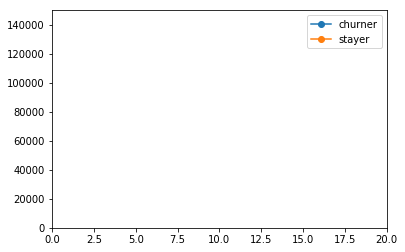

K=2


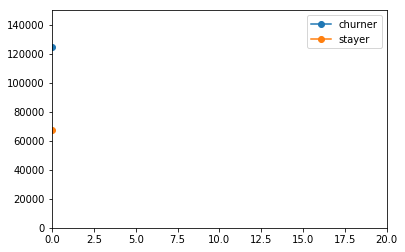

K=3


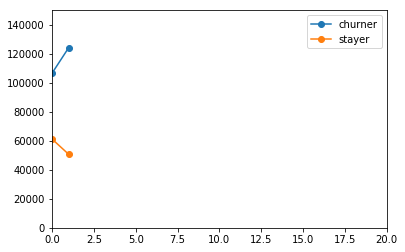

K=4


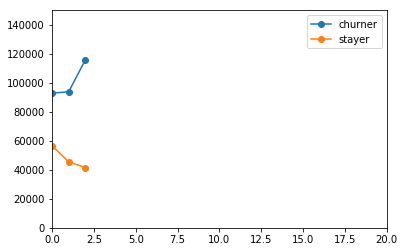

K=5


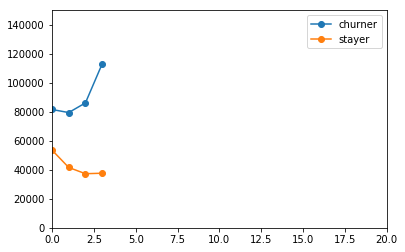

K=6


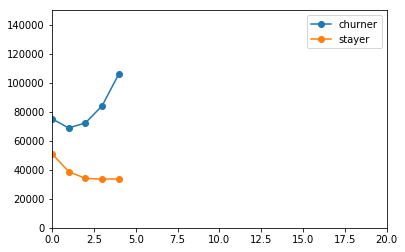

K=7


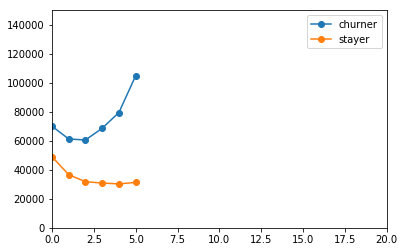

K=8


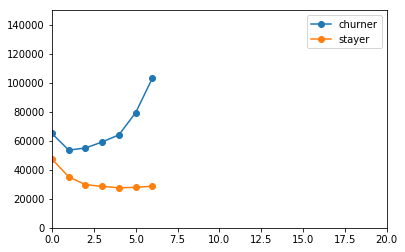

K=9


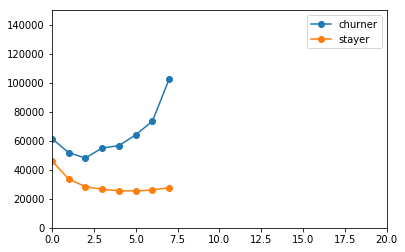

K=10


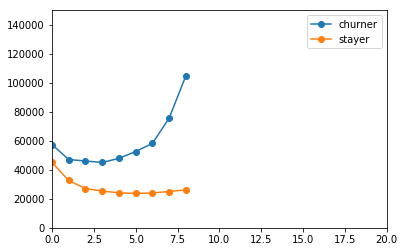

K=11


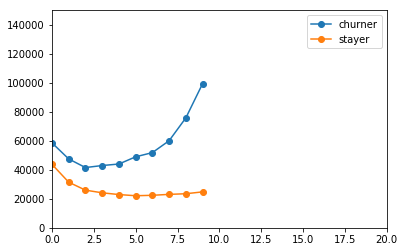

K=12


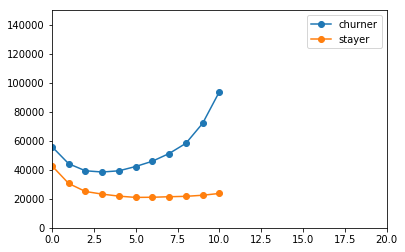

K=13


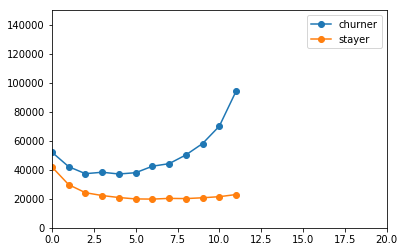

K=14


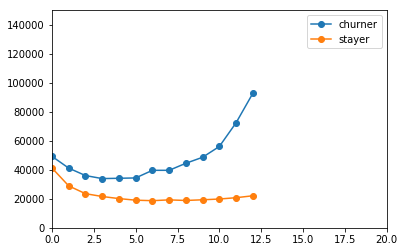

K=15


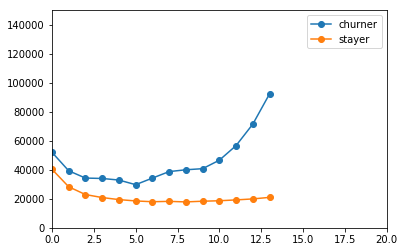

K=16


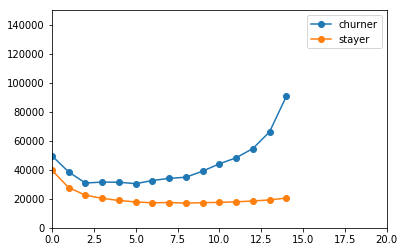

K=17


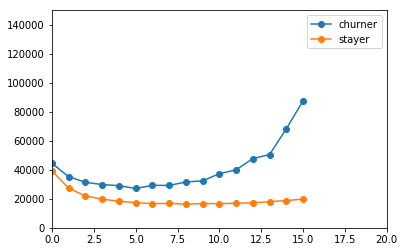

K=18


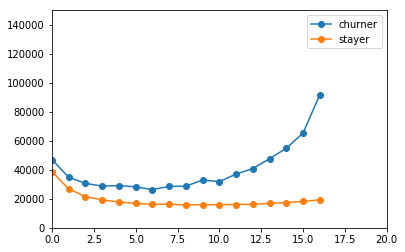

K=19


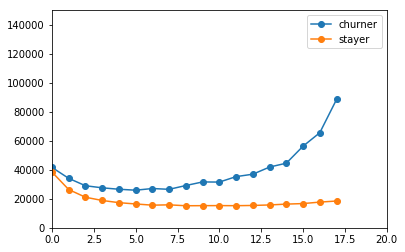

K=20


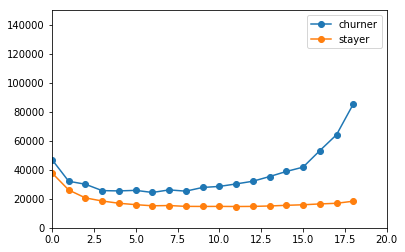

In [93]:
# Figure 2: Gap between posts
#    For a user who churns, gap between consecutive posts keeps increasing. 
#    Gaps for those who stay are much lower, and stabilize around 20,000 minutes,
#    indicating routine posting activity in every ≈2 weeks.
clist = []
slist = []
for K in list_of_K:
    subgroup = features_of_task1[K]
    churners_gap = []
    stayers_gap = []
    for i in range(2, K+1):
        gapK = 'gap{}'.format(i)
        sum_gapK = list(subgroup.groupby('is_churn')[gapK].sum())
        count_gapK = list(subgroup.groupby('is_churn')[gapK].count())
        if len(sum_gapK) < 2:
            break
        churners_gap.append(sum_gapK[1] / count_gapK[1])
        stayers_gap.append(sum_gapK[0] / count_gapK[0])

    clist.append(churners_gap)
    slist.append(stayers_gap)
    
    print("K={}".format(K))
    plt.plot(churners_gap, '-o', label='churner')
    plt.plot(stayers_gap, '-o', label='stayer')
    plt.legend()
    plt.axis((0,20,0,15e4))
    plt.show()

In [22]:
# Extract temporal features for task2
for T in list_of_T:
    users, posts = users_of_task2[T], posts_of_task2[T]
    features_of_task2[T]['gap1'] = getTimeGap1OfUser(users, posts)
    features_of_task2[T]['last_gap'] = getTimeLastGapOfPosts(posts).fillna(features_of_task2[T]['gap1'])
#     features_of_task2[T]['last_gap'] = getTimeLastGapOfPosts(posts).fillna(0)
    features_of_task2[T]['time_since_last_post'] = getTimeSinceLastPost(users, posts, T)
    features_of_task2[T]['mean_gap'] = getTimeMeanGap(posts)
  


        Id  PostTypeId  AcceptedAnswerId  ... BodyWordNum  ith  DataframeIndex
3126     9           1            1404.0  ...        16.0    1            3126
3127    11           1            1248.0  ...        23.0    2            3127
3128    12           2               NaN  ...       194.0    3            3128
3129   986           2               NaN  ...       117.0    4            3129
3130  1016           2               NaN  ...        47.0    5            3130

[5 rows x 13 columns]
        Id  PostTypeId  AcceptedAnswerId  ... BodyWordNum  ith  DataframeIndex
3126     9           1            1404.0  ...        16.0    1            3126
3127    11           1            1248.0  ...        23.0    2            3127
3128    12           2               NaN  ...       194.0    3            3128
3129   986           2               NaN  ...       117.0    4            3129
3130  1016           2               NaN  ...        47.0    5            3130

[5 rows x 13 columns]
      

3-2. Frequency features

In [0]:
# Frequency features 1: num_answers
# Frequency features 2: num_questions
def getNumAnswers(posts):
    answers = posts[posts['PostTypeId'] == 2]
    return answers.groupby('OwnerUserId')['OwnerUserId'].count()

def getNumQuestions(posts):
    questions = posts[posts['PostTypeId'] == 1]
    return questions.groupby('OwnerUserId')['OwnerUserId'].count()


In [0]:
# Frequency features 3: ans_ques_ratio
def getAnsQuesRatio(num_answers, num_questions):
    # Use Laplace Smoothing
    return (num_answers + 1) / (num_questions + 1)


In [0]:
# Frequency features 4: num_posts
def getNumPosts(posts):
    return posts.groupby('OwnerUserId')['OwnerUserId'].count().astype('float')

In [26]:
# Extract frequency features of task1
for K in list_of_K:
    users, posts = users_of_task1[K], posts_of_task1[K]
    features_of_task1[K]['num_answers'] = getNumAnswers(posts)
    features_of_task1[K]['num_questions'] = getNumQuestions(posts)
    features_of_task1[K] = features_of_task1[K].fillna({'num_answers':0, 'num_questions':0})
    features_of_task1[K]['ans_que_ratio'] = \
        getAnsQuesRatio(features_of_task1[K]['num_answers'], features_of_task1[K]['num_questions'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [0]:
# Extract frequency features of task2
for T in list_of_T:
    users, posts = users_of_task2[T], posts_of_task2[T]
    features_of_task2[T]['num_answers'] = getNumAnswers(posts)
    features_of_task2[T]['num_questions'] = getNumQuestions(posts)
    features_of_task2[T] = features_of_task2[T].fillna({'num_answers':0,'num_questions':0})
    features_of_task2[T]['ans_que_ratio'] = \
        getAnsQuesRatio(features_of_task2[T]['num_answers'], features_of_task2[T]['num_questions'])
    features_of_task2[T]['num_posts'] = getNumPosts(posts)

# Answers vs Churn probability


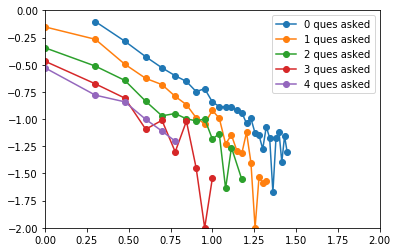

# Answers vs Churn probability


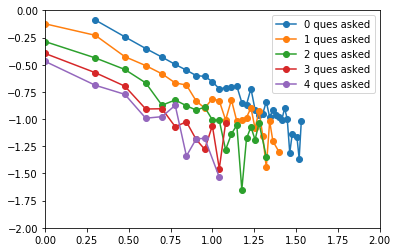

# Answers vs Churn probability


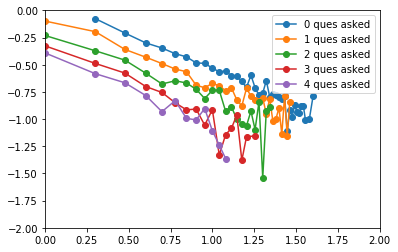

In [100]:
# Figure 3: # Answers vs Churn probability
#    The probability of churning for a user decreases the more answers s/he provides.
#    It is even lower if s/he asks more questions alongside.

min_num_users = 50
for T in list_of_T:
    task2 = features_of_task2[T]
    for num_que_ask in range(5):
        subgroup = task2[task2['num_questions'] == num_que_ask]
        churn_probs = []
        num_answers = list(set(subgroup['num_answers']))
        num_answers.sort()
        for num_ans in num_answers:
            subsubgroup = subgroup[subgroup['num_answers'] == num_ans]
            prob = sum(subsubgroup['is_churn']) / subsubgroup.shape[0]
            if subsubgroup.shape[0] >= min_num_users:
                churn_probs.append((num_ans, prob))

        plt.plot([np.log10(x[0]+1) for x in churn_probs],
                 [np.log10(x[1]+0.01) for x in churn_probs],
                 '-o',
                 label='{} ques asked'.format(num_que_ask))
    print("# Answers vs Churn probability")
    plt.legend()
    plt.axis((0,2,-2,0))
    plt.show()

3-3. Knowledge features

In [0]:
# For the fast extraction, prepare questions x answers
def preprocessForKnowledgeFeaturesForTask1(users, posts, all_posts):
    answers = posts[posts['PostTypeId'] == 2]
    questions = posts[posts['PostTypeId'] == 1]
    all_answers = all_posts[all_posts['PostTypeId'] == 2]
    all_questions = all_posts[all_posts['PostTypeId'] == 1]
    
    qnta = all_answers.set_index('ParentId')\
        .join(questions, how='inner',\
              lsuffix='A', rsuffix='Q')
    tqna = answers.set_index('ParentId')\
        .join(all_questions, how='inner',\
              lsuffix='A', rsuffix='Q')
    return answers, questions, qnta, tqna

In [0]:
# For the fast extraction, prepare questions x answers
def preprocessForKnowledgeFeaturesForTask2(users, posts):
    answers = posts[posts['PostTypeId'] == 2]
    questions = posts[posts['PostTypeId'] == 1]
    qna = answers\
        .set_index('ParentId').join(questions, how='inner',\
                                    lsuffix='A', rsuffix='Q')
    return answers, questions, qna, qna

In [0]:
# Knowledge features 1: accepted_answerer_rep
def getRepOfAcceptedAnswerer(users, answers, questions, qnta, tqna):
    reputations = users.loc[:, ['Reputation']]
    rep_accepted_ans = qnta[qnta['AcceptedAnswerIdQ'] == qnta['IdA']]\
        .set_index('OwnerUserIdA')\
        .join(reputations, how='inner')\
        .groupby('OwnerUserIdQ')['Reputation'].mean()
    return rep_accepted_ans


In [0]:
# Knowledge features 2: max_rep_answerer 
def getMaxRepAmongAnswerer(users, answers, questions, qnta, tqna):
    reputations = users.loc[:, ['Reputation']]
    rep_max_ans = qnta.set_index('OwnerUserIdA')\
        .join(reputations, how='inner')\
        .groupby('OwnerUserIdQ')['Reputation'].max()
    return rep_max_ans


In [0]:
# Knowledge features 3: num_que_answered
def getNumQueAnswered(users, answers, questions, qnta, tqna):
    # number of questions posted by the user that got answered
    #questions = posts[posts['PostTypeId'] == 1]
    answered_questions = questions[questions['AnswerCount'] > 0]
    return answered_questions.groupby('OwnerUserId')['AnswerCount'].count()


In [0]:
# Knowledge features 4: time_for_first_ans
def getTimeForFirstAns(users, answers, questions, qnta, tqna):
    tmp =  qnta[qnta['CreationDateQ'] < qnta['CreationDateA']]
    tmp['time_for_ans'] = (tmp['CreationDateA'] - tmp['CreationDateQ']).dt.total_seconds() / 60
    questions['time_for_first_ans'] = tmp.groupby(by=tmp.index)['time_for_ans'].min()
    return questions.groupby('OwnerUserId')['time_for_first_ans'].mean()


In [0]:
# Knowledge features 5: rep_questioner
def getAvgRepOfQuestioner(users, answers, questions, qnta, tqna):
    # Avg. reputation of the user whose question was answered
    reputations = users.loc[:, ['Reputation']]
    rep_accepted_ans = tqna.set_index('OwnerUserIdQ')\
        .join(reputations, how='inner')\
        .groupby('OwnerUserIdA')['Reputation'].mean()
    return rep_accepted_ans


In [0]:
# Knowledge features 6: rep_answerers
def getAvgRepOfAnswerer(users, answers, questions, qnta, tqna):
    # Avg. reputation of the users who answered the question
    reputations = users.loc[:, ['Reputation']]
    rep_accepted_ans = qnta.set_index('OwnerUserIdA')\
        .join(reputations, how='inner')\
        .groupby('OwnerUserIdQ')['Reputation'].mean()
    return rep_accepted_ans


In [0]:
# Knowledge features 7: rep_co_answerers
def getAvgRepOfCoAnswerer(users, answers, questions, qnta, tqna):
    reputations = users.loc[:, ['Reputation']]    
    rep_ans = answers.set_index('OwnerUserId')\
        .join(reputations, how='inner')\
        .set_index('ParentId')\
        .join(questions, how='inner', lsuffix='A', rsuffix='Q')
    avg_rep_ans = rep_ans.groupby(by=rep_ans.index)['Reputation'].mean()
    rep_co_answerer = answers.set_index('ParentId')\
        .join(avg_rep_ans, how='inner')\
        .set_index('OwnerUserId')
    return rep_co_answerer.groupby(by=rep_co_answerer.index)['Reputation'].mean()


In [0]:
# Knowledge features 8: num_answers_recvd
def getAvgNumAnsReceived(users, answers, questions, qnta, tqna):
    #questions = posts[posts['PostTypeId'] == 1]
    return questions.fillna({'AnswerCount': 0}).groupby('OwnerUserId')['AnswerCount'].mean()


In [38]:
# Extract knowledge features of task 1
for K in list_of_K:
    print("Extract knowledge features of task1(K=",K,")")
    users, posts = users_of_task1[K], posts_of_task1[K]
    answers, questions, qnta, tqna = preprocessForKnowledgeFeaturesForTask1(users, posts, posts_df)
    features_of_task1[K]['accepted_answerer_rep'] = getRepOfAcceptedAnswerer(users, answers, questions,  qnta, tqna)
    features_of_task1[K]['max_rep_answerer'] = getMaxRepAmongAnswerer(users, answers, questions,  qnta, tqna)
    features_of_task1[K]['num_que_answered'] = getNumQueAnswered(users, answers, questions,  qnta, tqna)
    features_of_task1[K]['time_for_first_ans'] = getTimeForFirstAns(users, answers, questions, qnta, tqna)
    features_of_task1[K]['rep_questioner'] = getAvgRepOfQuestioner(users, answers, questions, qnta, tqna)
    features_of_task1[K]['rep_answerers'] = getAvgRepOfAnswerer(users, answers, questions, qnta, tqna)
    features_of_task1[K]['rep_co_answerers'] = getAvgRepOfCoAnswerer(users, answers, questions, qnta, tqna)
    features_of_task1[K]['num_answers_recvd'] = getAvgNumAnsReceived(users, answers, questions, qnta, tqna)
    

Extract knowledge features of task1(K= 1 )


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Extract knowledge features of task1(K= 2 )
Extract knowledge features of task1(K= 3 )
Extract knowledge features of task1(K= 4 )
Extract knowledge features of task1(K= 5 )
Extract knowledge features of task1(K= 6 )
Extract knowledge features of task1(K= 7 )
Extract knowledge features of task1(K= 8 )
Extract knowledge features of task1(K= 9 )
Extract knowledge features of task1(K= 10 )
Extract knowledge features of task1(K= 11 )
Extract knowledge features of task1(K= 12 )
Extract knowledge features of task1(K= 13 )
Extract knowledge features of task1(K= 14 )
Extract knowledge features of task1(K= 15 )
Extract knowledge features of task1(K= 16 )
Extract knowledge features of task1(K= 17 )
Extract knowledge features of task1(K= 18 )
Extract knowledge features of task1(K= 19 )
Extract knowledge features of task1(K= 20 )


In [39]:
for T in list_of_T:
    print("Extract knowledge features of task2(T=)",T,")")
    users, posts = users_of_task2[T], posts_of_task2[T]
    answers, questions, qna, qna1 = preprocessForKnowledgeFeaturesForTask2(users, posts)
    features_of_task2[T]['accepted_answerer_rep'] = getRepOfAcceptedAnswerer(users, answers, questions, qna, qna1)
    features_of_task2[T]['max_rep_answerer'] = getMaxRepAmongAnswerer(users, answers, questions, qna, qna1)
    features_of_task2[T]['num_que_answered'] = getNumQueAnswered(users, answers, questions, qna, qna1)
    features_of_task2[T]['time_for_first_ans'] = getTimeForFirstAns(users, answers, questions, qna, qna1)
    features_of_task2[T]['rep_questioner'] = getAvgRepOfQuestioner(users, answers, questions, qna, qna1)
    features_of_task2[T]['rep_answerers'] = getAvgRepOfAnswerer(users, answers, questions, qna, qna1)
    features_of_task2[T]['rep_co_answerers'] = getAvgRepOfCoAnswerer(users, answers, questions, qna, qna1)
    features_of_task2[T]['num_answers_recvd'] = getAvgNumAnsReceived(users, answers, questions, qna, qna1)

Extract knowledge features of task2(T=) 7 )


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Extract knowledge features of task2(T=) 15 )
Extract knowledge features of task2(T=) 30 )


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


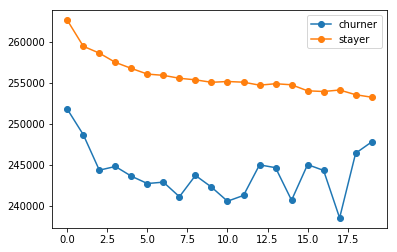

In [113]:
# Figure 4: K vs Time taken for the first answer to arrive
#  The more the time taken for a user to receive an answer, 
#  the lesser the satisfaction level and the more the chances of churning.
churners_time = []
stayers_time = []
for K in list_of_K:
    subgroup = features_of_task1[K]
    churners = subgroup[subgroup['is_churn'] == 1][subgroup['time_for_first_ans'] > 0] 
    stayers = subgroup[subgroup['is_churn'] == 0][subgroup['time_for_first_ans'] > 0]
    churners_time.append(churners['time_for_first_ans'].mean())
    stayers_time.append(stayers['time_for_first_ans'].mean())
    

plt.plot(churners_time, '-o', label='churner')
plt.plot(stayers_time, '-o', label='stayer')
plt.legend()
# plt.axis((0,20,8e3,22e3))
plt.show()

3-4. Speed features

In [0]:
# Speed features 1: answering_speed
def getAnsweringSpeed(users, answers, questions, qnta, tqna):
    tmp =  qnta[qnta['CreationDateQ'] < qnta['CreationDateA']]
    tmp['time_for_ans'] = (tmp['CreationDateA'] - tmp['CreationDateQ']).dt.total_seconds() / 60
    answers['total_time_for_ans'] = tmp.groupby('OwnerUserIdA')['time_for_ans'].sum()
    return answers.groupby('OwnerUserId')['CreationDate'].count() / answers['total_time_for_ans']


3-5. Quality features

In [0]:
# Quality features 1: ans_score
# Quality features 2: que_score
def getScoreOfAnswers(users, answers, questions, qnta, tqna):
    return answers.groupby('OwnerUserId')['Score'].sum()

def getScoreOfQuestions(users, answers, questions, qnta, tqna):
    return questions.groupby('OwnerUserId')['Score'].sum()


3-6. Consistency features

In [0]:
# Consistency features 1: ans_stddev
# Consistency features 2: que_stddev
def getStdevOfScoresOfAnswers(users, answers, questions, qnta, tqna):
    return answers.groupby('OwnerUserId')['Score'].std()

def getStdevOfScoresOfQuestions(users, answers, questions, qnta, tqna):
    return questions.groupby('OwnerUserId')['Score'].std()


3-7. Gratitude features

In [0]:
# Gratitude features 1: ans_comments
# Gratitude features 2: que_comments
def getAvgNumOfAnswers(users, answers, questions, qnta, tqna):
    return answers.groupby('OwnerUserId')['CommentCount'].mean()

def getAvgNumOfQuestions(users, answers, questions, qnta, tqna):
    return questions.groupby('OwnerUserId')['CommentCount'].mean()


3-8. Competitiveness features

In [0]:
# Competitiveness features 1: relative_rank_pos
def getRelRankPos(users, answers, questions, qnta, tqna):
    
    tmp_rank = answers.groupby('ParentId')['Score'].rank(method='first', ascending=False)
    answers_rank = questions.set_index('Id').join(tmp_rank, how='inner', rsuffix='R')
    return answers_rank['AnswerCount'] / answers_rank['ScoreR']


3-9. Content features

In [0]:
# Content features 1: ans_length
# Content features 2: que_length
def getLengthOfAnswers(users, answers, questions, qnta, tqna):
    return answers.groupby('OwnerUserId')['BodyWordNum'].mean()

def getLengthOfQuestions(users, answers, questions, qnta, tqna):
    return questions.groupby('OwnerUserId')['BodyWordNum'].mean()

In [46]:
# Extract knowledge features of task 1
for K in list_of_K:
    print("Extract other features of task1(K=",K,")")
    users, posts = users_of_task1[K], posts_of_task1[K]
    answers, questions, qnta, tqna = preprocessForKnowledgeFeaturesForTask1(users, posts, posts_df)
    features_of_task1[K]['answering_speed'] = getAnsweringSpeed(users, answers, questions,  qnta, tqna)
    features_of_task1[K]['ans_score'] = getScoreOfAnswers(users, answers, questions,  qnta, tqna)
    features_of_task1[K]['que_score'] = getScoreOfQuestions(users, answers, questions,  qnta, tqna)
    features_of_task1[K]['ans_stddev'] = getStdevOfScoresOfAnswers(users, answers, questions, qnta, tqna)
    features_of_task1[K]['que_stddev'] = getStdevOfScoresOfQuestions(users, answers, questions, qnta, tqna)
    features_of_task1[K]['ans_comments'] = getAvgNumOfAnswers(users, answers, questions, qnta, tqna)
    features_of_task1[K]['que_comments'] = getAvgNumOfQuestions(users, answers, questions, qnta, tqna)
    features_of_task1[K]['relative_rank_pos'] = getRelRankPos(users, answers, questions, qnta, tqna)
    features_of_task1[K]['ans_length'] = getLengthOfAnswers(users, answers, questions, qnta, tqna)
    features_of_task1[K]['que_length'] = getLengthOfQuestions(users, answers, questions, qnta, tqna)
    

Extract other features of task1(K= 1 )


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Extract other features of task1(K= 2 )
Extract other features of task1(K= 3 )
Extract other features of task1(K= 4 )
Extract other features of task1(K= 5 )
Extract other features of task1(K= 6 )
Extract other features of task1(K= 7 )
Extract other features of task1(K= 8 )
Extract other features of task1(K= 9 )
Extract other features of task1(K= 10 )
Extract other features of task1(K= 11 )
Extract other features of task1(K= 12 )
Extract other features of task1(K= 13 )
Extract other features of task1(K= 14 )
Extract other features of task1(K= 15 )
Extract other features of task1(K= 16 )
Extract other features of task1(K= 17 )
Extract other features of task1(K= 18 )
Extract other features of task1(K= 19 )
Extract other features of task1(K= 20 )


In [47]:
for T in list_of_T:
    print("Extract Other features of task2(T=)",T,")")
    users, posts = users_of_task2[T], posts_of_task2[T]
    answers, questions, qna, qna1 = preprocessForKnowledgeFeaturesForTask2(users, posts)
    features_of_task2[T]['answering_speed'] = getAnsweringSpeed(users, answers, questions, qna, qna1)
    features_of_task2[T]['ans_score'] = getScoreOfAnswers(users, answers, questions, qna, qna1)
    features_of_task2[T]['que_score'] = getScoreOfQuestions(users, answers, questions, qna, qna1)
    features_of_task2[T]['ans_stddev'] = getStdevOfScoresOfAnswers(users, answers, questions, qna, qna1)
    features_of_task2[T]['que_stddev'] = getStdevOfScoresOfQuestions(users, answers, questions, qna, qna1)
    features_of_task2[T]['ans_comments'] = getAvgNumOfAnswers(users, answers, questions, qna, qna1)
    features_of_task2[T]['que_comments'] = getAvgNumOfQuestions(users, answers, questions, qna, qna1)
    features_of_task2[T]['relative_rank_pos'] = getRelRankPos(users, answers, questions, qna, qna1)
    features_of_task1[K]['ans_length'] = getLengthOfAnswers(users, answers, questions, qna, qna1)
    features_of_task1[K]['que_length'] = getLengthOfQuestions(users, answers, questions, qna, qna1)

Extract Other features of task2(T=) 7 )


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Extract Other features of task2(T=) 15 )
Extract Other features of task2(T=) 30 )


3-10. Answering features

In [0]:
# Gratitude features 1: Average of Answer Count
def getAvgNumOfAnswerCount(users, answers, questions, qnta, tqna):
    return tqna.groupby('OwnerUserIdA')['AnswerCountQ'].sum()

In [0]:
# Gratitude features 1: First Type of Posting
def getFirstPostType(posts):
    tmp = posts[posts['ith'] == 1]['OwnerUserId'].to_frame()
    tmp = tmp.set_index('OwnerUserId')
    return posts[posts['OwnerUserId'].isin(tmp.index)]['PostTypeId'].apply(lambda post_type: post_type if post_type == 2 else 0)

In [0]:
# Gratitude features 1: Total # of comment
def getTotalNumOfComments(users, answers, questions,  qnta, tqna):
    tqna['total_comment'] = tqna['CommentCountA'] + tqna['CommentCountQ'] / tqna['AnswerCountQ']
    return tqna.groupby('OwnerUserIdQ')['total_comment'].sum()

In [57]:
for K in list_of_K:
    print("Extract other features of task1(K=",K,")")
    users, posts = users_of_task1[K], posts_of_task1[K]
    answers, questions, qnta, tqna = preprocessForKnowledgeFeaturesForTask1(users, posts, posts_df)
    features_of_task1[K]['num_of_ans_count'] = getAvgNumOfAnswerCount(users, answers, questions,  qnta, tqna)
    features_of_task1[K]['first_post_type'] = getFirstPostType(posts)
    features_of_task1[K]['total_comment'] = getTotalNumOfComments(users, answers, questions,  qnta, tqna)

Extract other features of task1(K= 1 )
Extract other features of task1(K= 2 )
Extract other features of task1(K= 3 )
Extract other features of task1(K= 4 )
Extract other features of task1(K= 5 )
Extract other features of task1(K= 6 )
Extract other features of task1(K= 7 )
Extract other features of task1(K= 8 )
Extract other features of task1(K= 9 )
Extract other features of task1(K= 10 )
Extract other features of task1(K= 11 )
Extract other features of task1(K= 12 )
Extract other features of task1(K= 13 )
Extract other features of task1(K= 14 )
Extract other features of task1(K= 15 )
Extract other features of task1(K= 16 )
Extract other features of task1(K= 17 )
Extract other features of task1(K= 18 )
Extract other features of task1(K= 19 )
Extract other features of task1(K= 20 )


In [58]:
for T in list_of_T:
    print("Extract Other features of task2(T=)",T,")")
    users, posts = users_of_task2[T], posts_of_task2[T]
    answers, questions, qna, qna1 = preprocessForKnowledgeFeaturesForTask2(users, posts)
    features_of_task2[T]['num_of_ans_count'] = getAvgNumOfAnswerCount(users, answers, questions, qna, qna1)
    features_of_task2[T]['first_post_type'] = getFirstPostType(posts)
    features_of_task2[T]['total_comment'] = getTotalNumOfComments(users, answers, questions, qna, qna1)

Extract Other features of task2(T=) 7 )
Extract Other features of task2(T=) 15 )
Extract Other features of task2(T=) 30 )


In [59]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [64]:
# Store the whole features of task1 to Google Drive
# list_of_K = range(1, 21)
# features_of_task1 = {}

for K in list_of_K:
#     features_of_task1[K]
#     12-hUBN2LIt0d2aLLgNQ9viM6WRs4DWF4
    store_df_at_google_drive('task1_{}posts_features_all2.csv'.format(K), features_of_task1[K])
#     features_of_task1[K] = load_df_at_google_drive('task1_{}posts_features_all.csv'.format(K))
    #features_of_task1[K].to_pickle('task1_{}posts_important_features.pkl'.format(K))
    #features_of_task1[K].to_csv('task1_{}posts_important_features.csv'.format(K))

ApiRequestError: ignored

In [0]:
# list_of_T = [7, 15, 30]
# features_of_task2 = {}

for T in list_of_T:
    store_df_at_google_drive('task2_{}posts_features_all2.csv'.format(T), features_of_task2[T])
#     features_of_task2[T] = load_df_at_google_drive('task2_{}posts_features_all.csv'.format(T))
    #features_of_task2[T].to_pickle('task2_{}days_important_features.pkl'.format(T))
    #features_of_task2[T].to_csv('task2_{}days_important_features.csv'.format(T))


answering, Task 1, K=1
    columns: ['num_answers', 'num_questions', 'ans_que_ratio', 'rep_co_answerers', 'num_of_ans_count', 'first_post_type', 'total_comment']


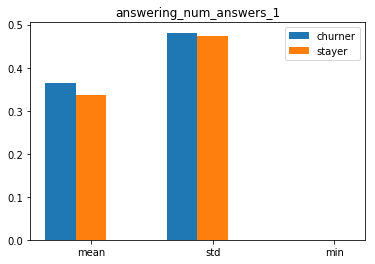

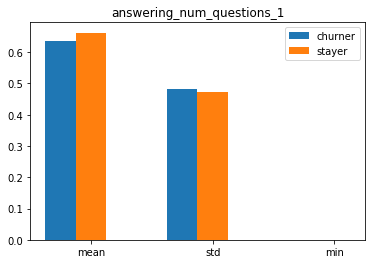

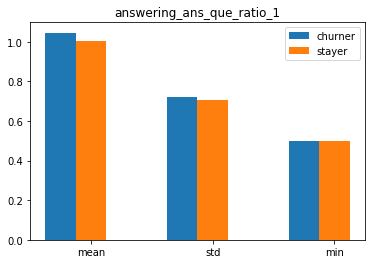

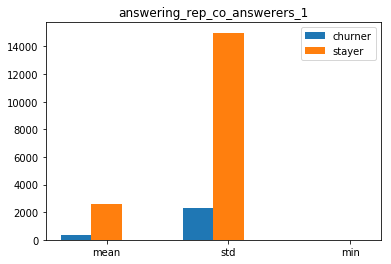

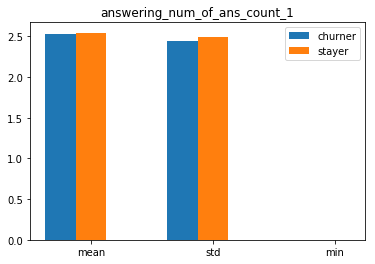

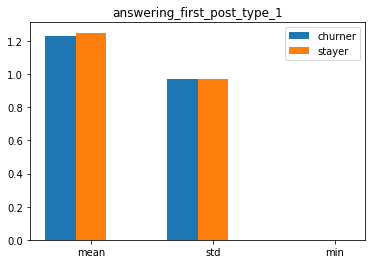

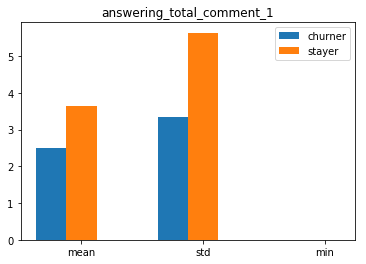


answering, Task 1, K=2
    columns: ['num_answers', 'num_questions', 'ans_que_ratio', 'rep_co_answerers', 'num_of_ans_count', 'first_post_type', 'total_comment']


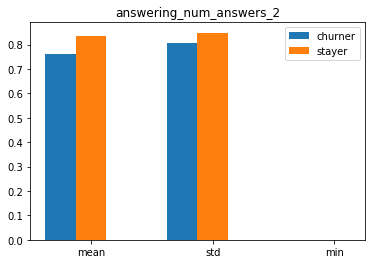

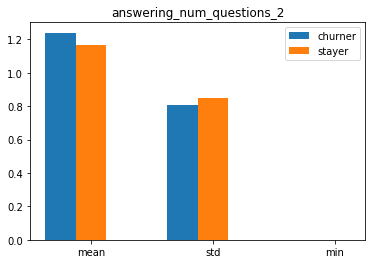

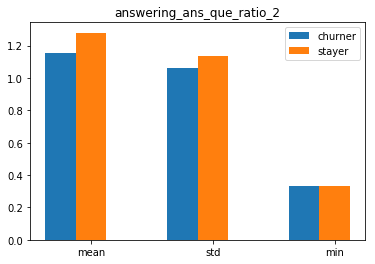

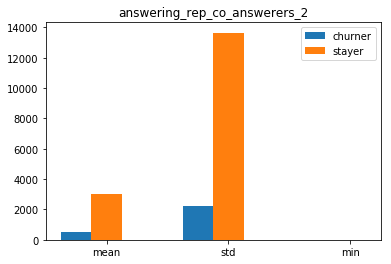

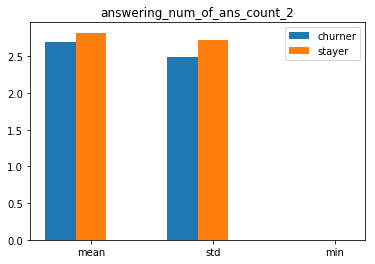

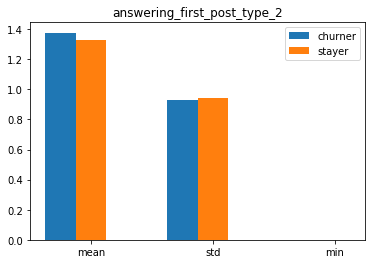

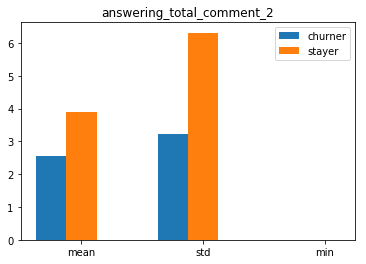


answering, Task 1, K=3
    columns: ['num_answers', 'num_questions', 'ans_que_ratio', 'rep_co_answerers', 'num_of_ans_count', 'first_post_type', 'total_comment']


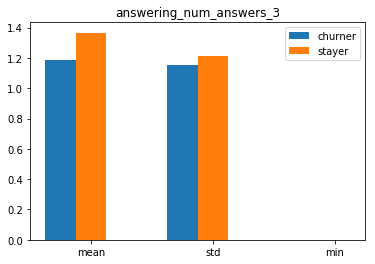

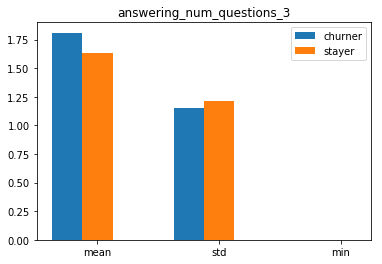

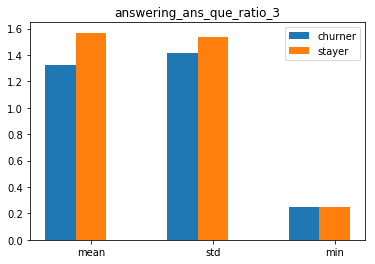

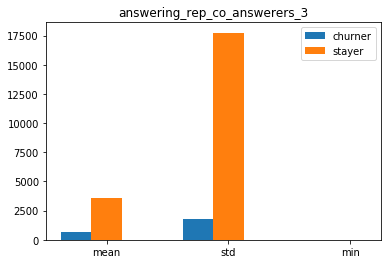

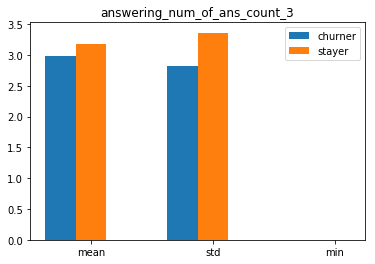

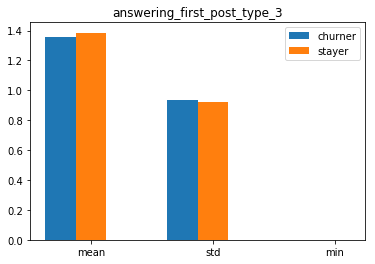

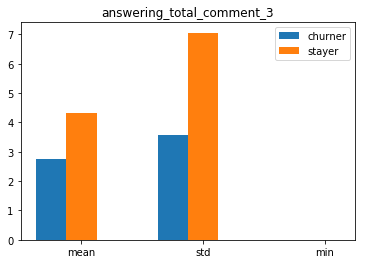


answering, Task 1, K=4
    columns: ['num_answers', 'num_questions', 'ans_que_ratio', 'rep_co_answerers', 'num_of_ans_count', 'first_post_type', 'total_comment']


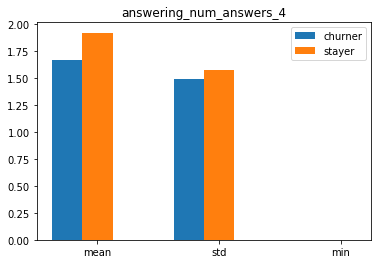

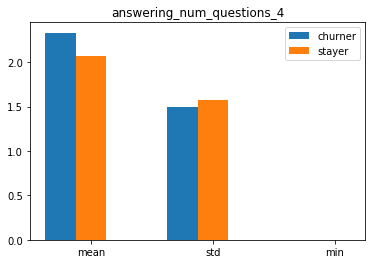

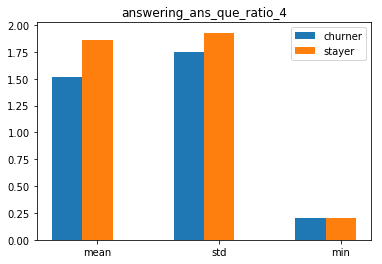

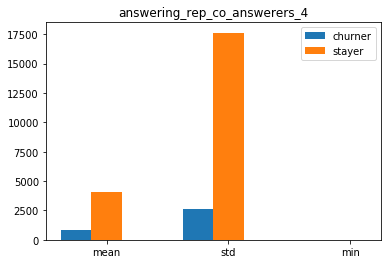

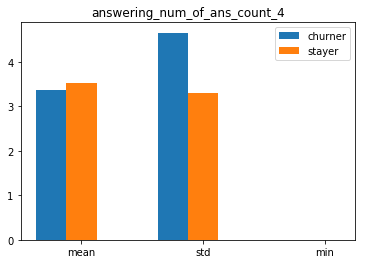

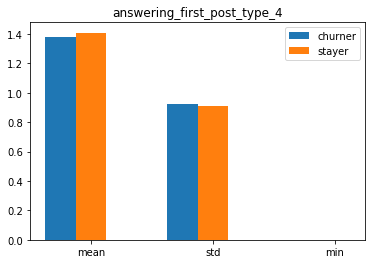

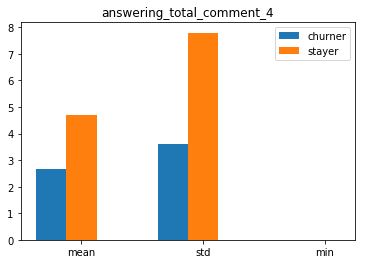


answering, Task 1, K=5
    columns: ['num_answers', 'num_questions', 'ans_que_ratio', 'rep_co_answerers', 'num_of_ans_count', 'first_post_type', 'total_comment']


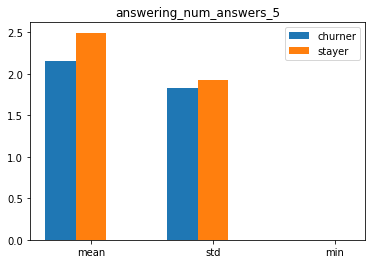

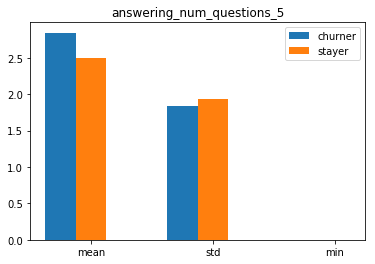

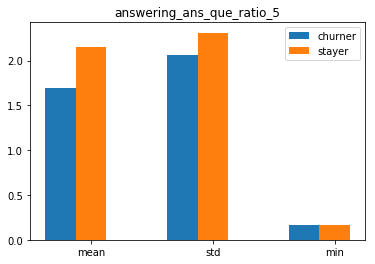

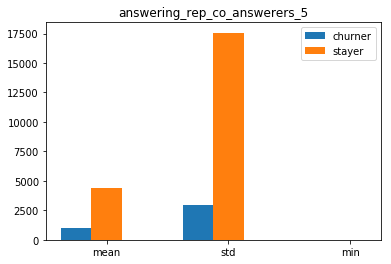

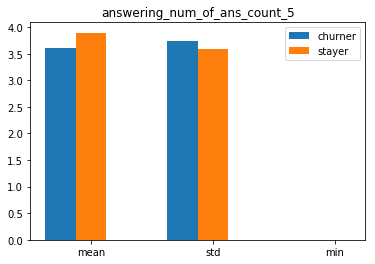

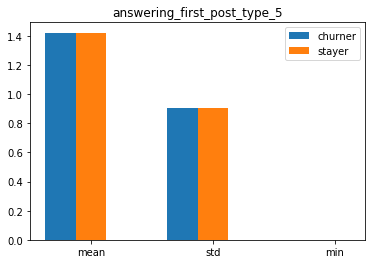

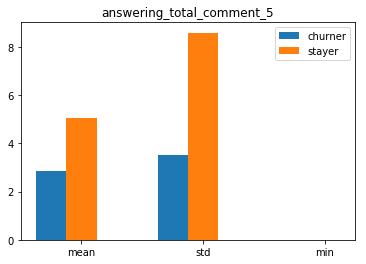


answering, Task 1, K=6
    columns: ['num_answers', 'num_questions', 'ans_que_ratio', 'rep_co_answerers', 'num_of_ans_count', 'first_post_type', 'total_comment']


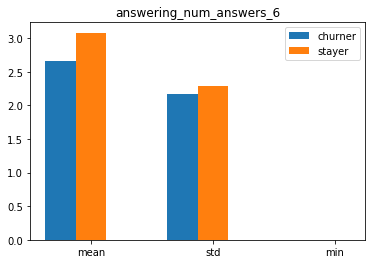

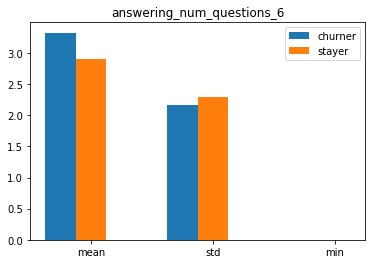

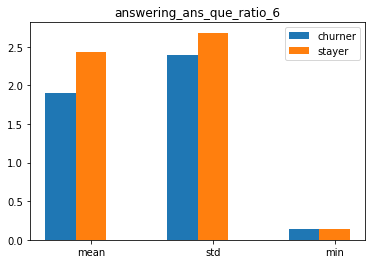

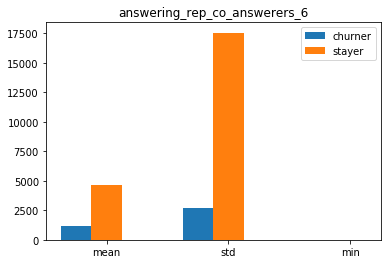

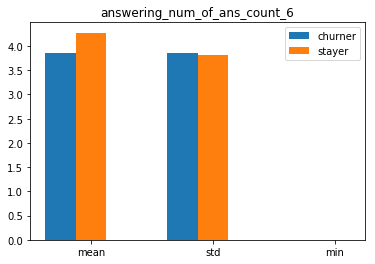

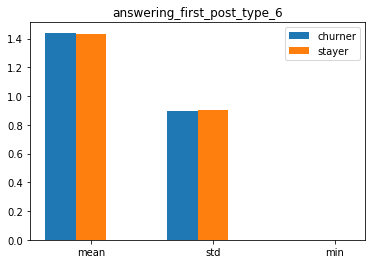

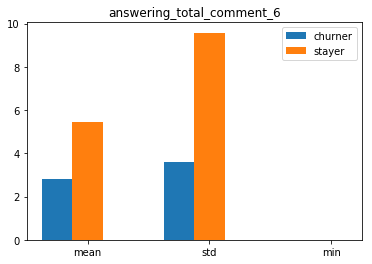


answering, Task 1, K=7
    columns: ['num_answers', 'num_questions', 'ans_que_ratio', 'rep_co_answerers', 'num_of_ans_count', 'first_post_type', 'total_comment']


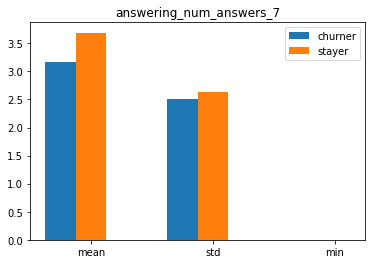

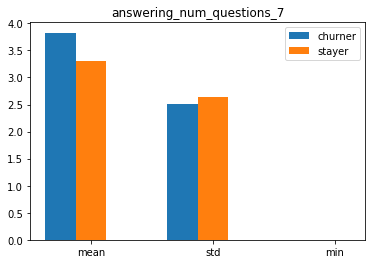

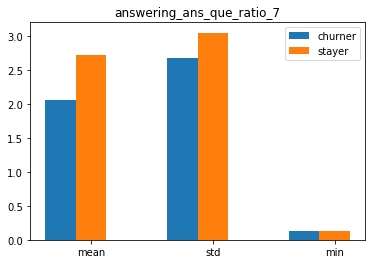

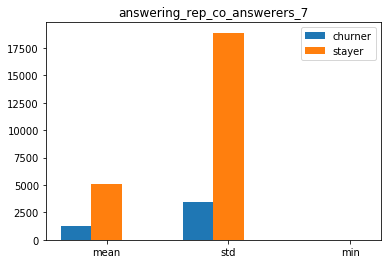

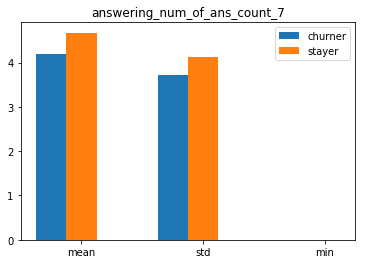

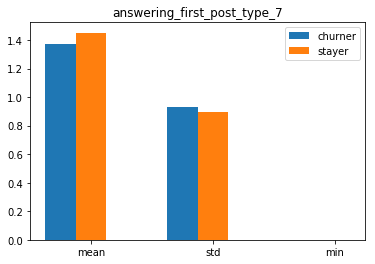

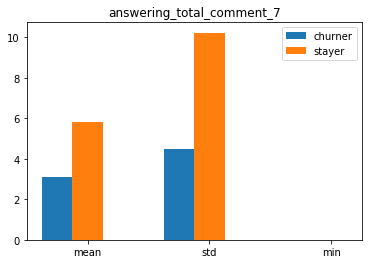


answering, Task 1, K=8
    columns: ['num_answers', 'num_questions', 'ans_que_ratio', 'rep_co_answerers', 'num_of_ans_count', 'first_post_type', 'total_comment']


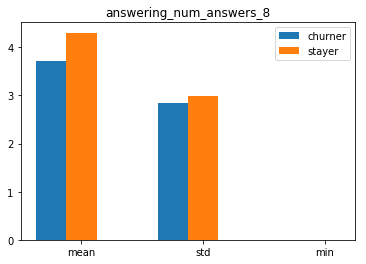

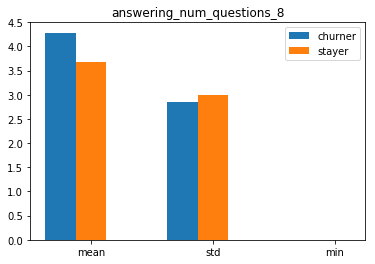

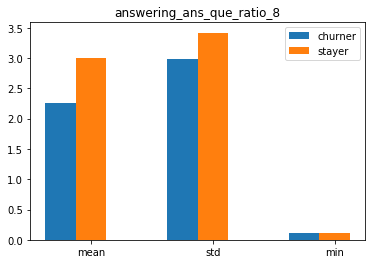

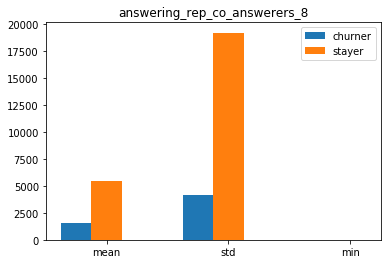

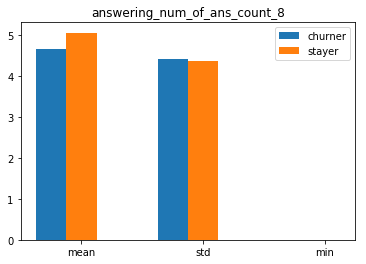

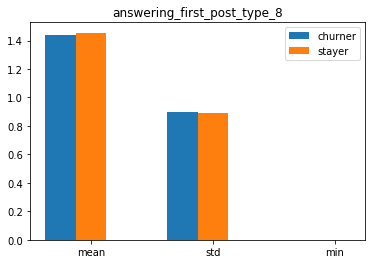

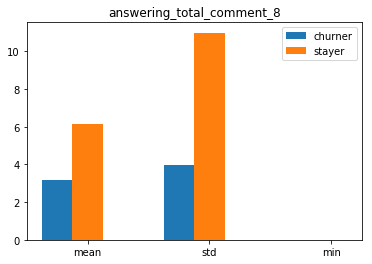


answering, Task 1, K=9
    columns: ['num_answers', 'num_questions', 'ans_que_ratio', 'rep_co_answerers', 'num_of_ans_count', 'first_post_type', 'total_comment']


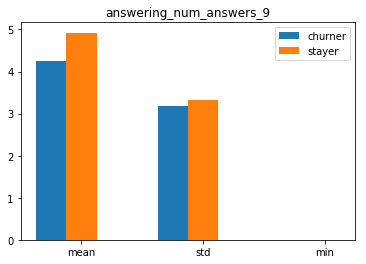

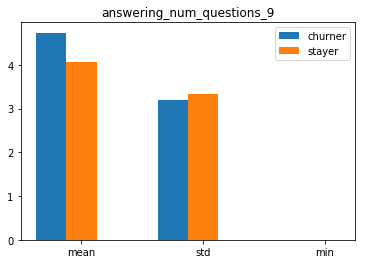

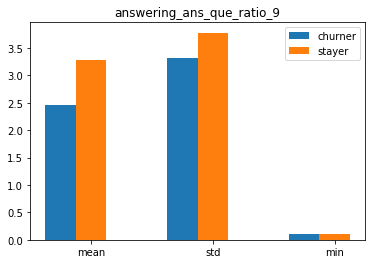

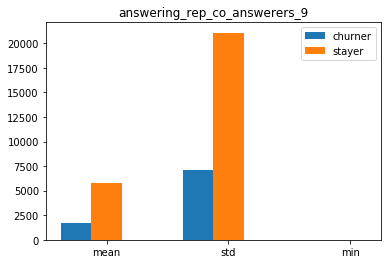

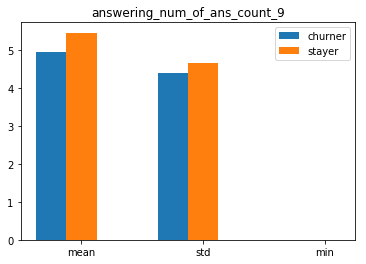

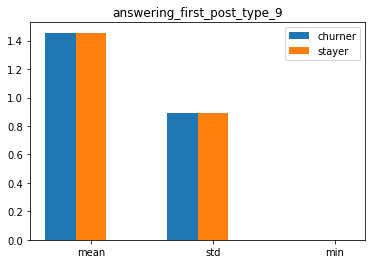

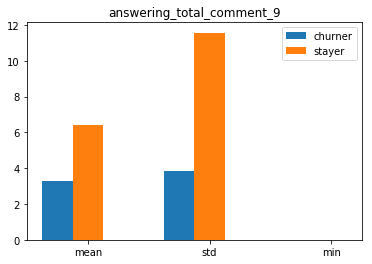


answering, Task 1, K=10
    columns: ['num_answers', 'num_questions', 'ans_que_ratio', 'rep_co_answerers', 'num_of_ans_count', 'first_post_type', 'total_comment']


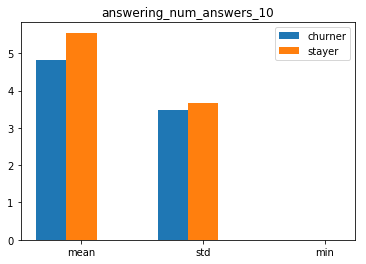

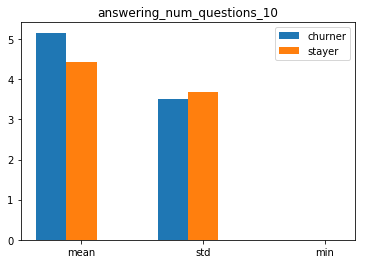

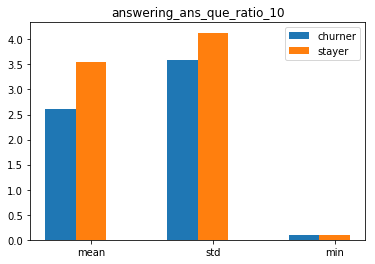

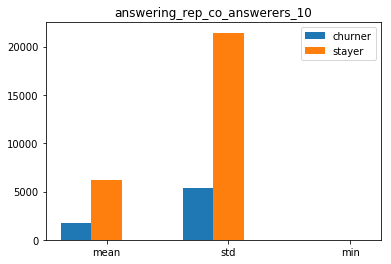

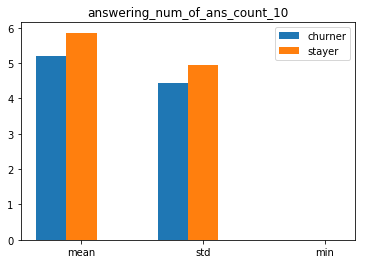

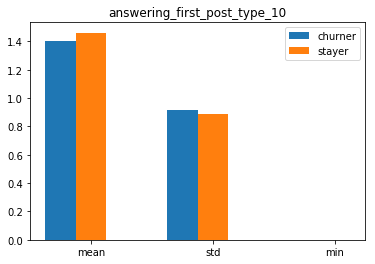

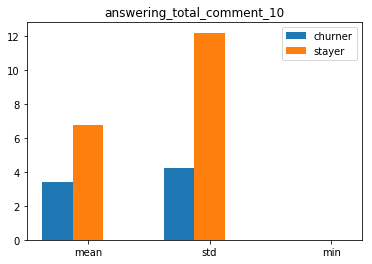


answering, Task 1, K=11
    columns: ['num_answers', 'num_questions', 'ans_que_ratio', 'rep_co_answerers', 'num_of_ans_count', 'first_post_type', 'total_comment']


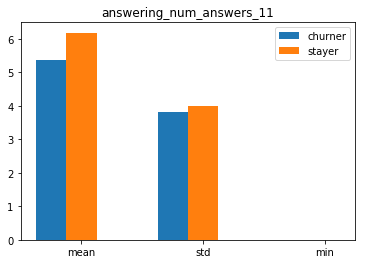

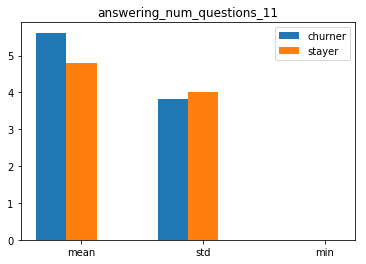

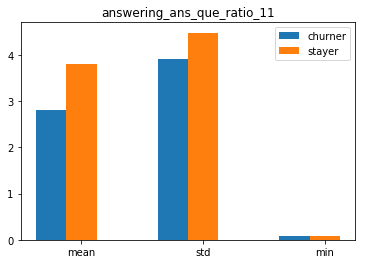

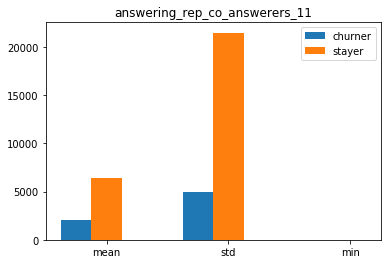

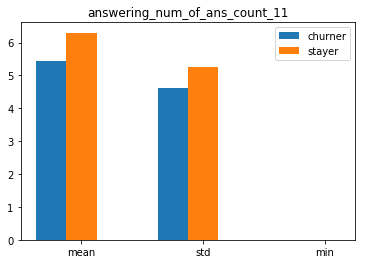

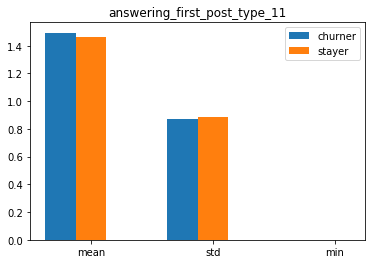

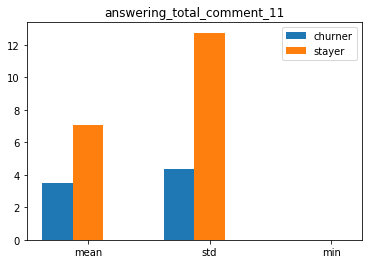


answering, Task 1, K=12
    columns: ['num_answers', 'num_questions', 'ans_que_ratio', 'rep_co_answerers', 'num_of_ans_count', 'first_post_type', 'total_comment']


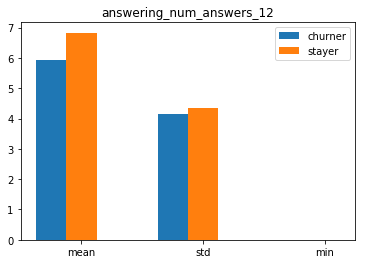

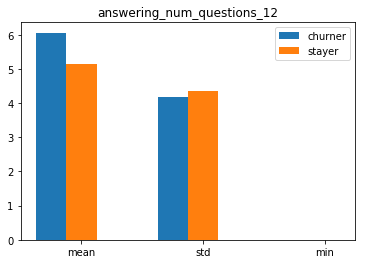

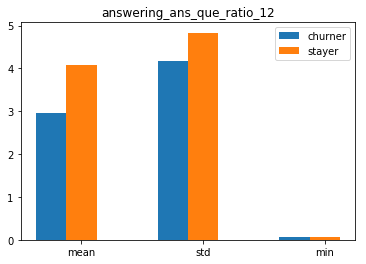

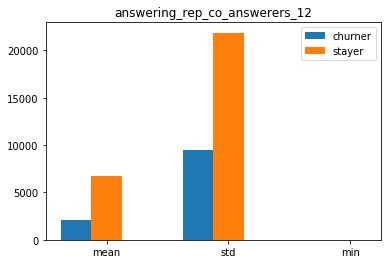

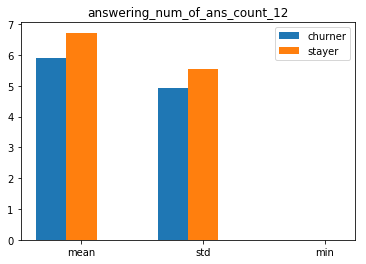

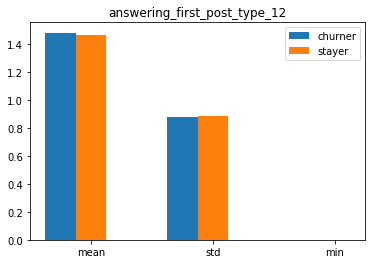

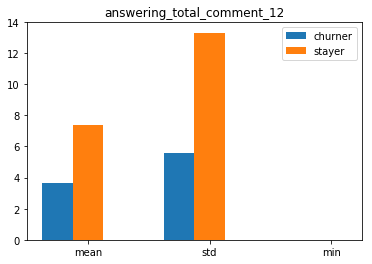


answering, Task 1, K=13
    columns: ['num_answers', 'num_questions', 'ans_que_ratio', 'rep_co_answerers', 'num_of_ans_count', 'first_post_type', 'total_comment']


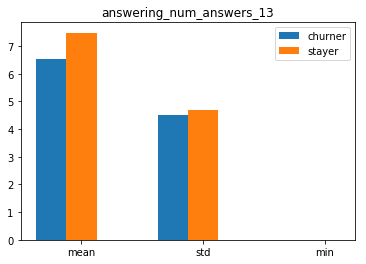

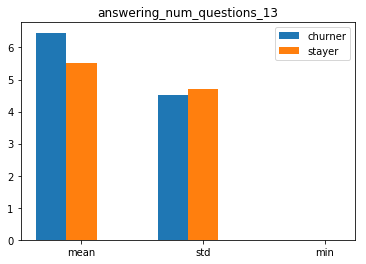

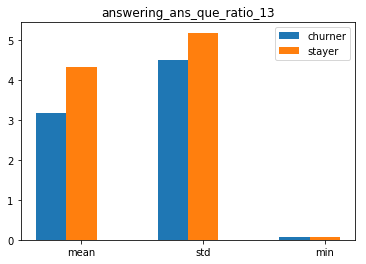

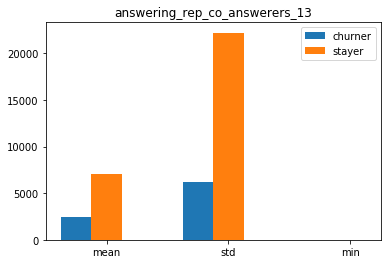

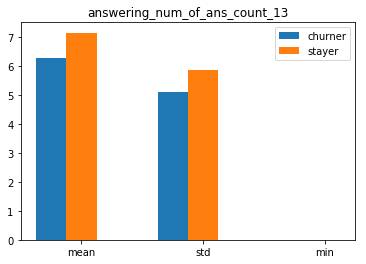

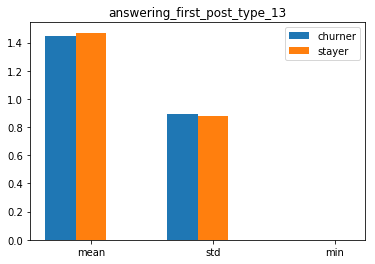

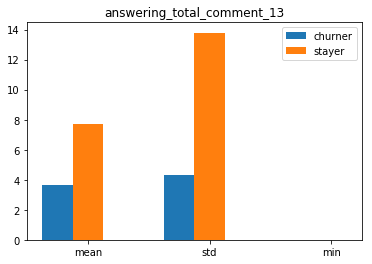


answering, Task 1, K=14
    columns: ['num_answers', 'num_questions', 'ans_que_ratio', 'rep_co_answerers', 'num_of_ans_count', 'first_post_type', 'total_comment']


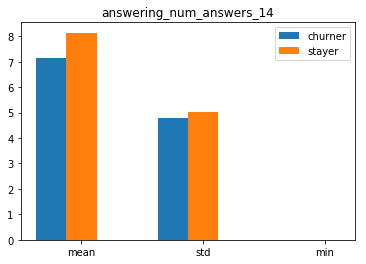

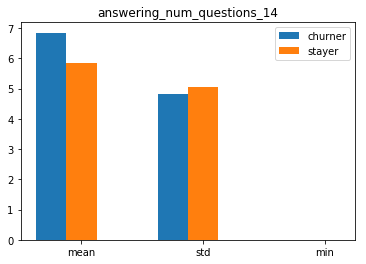

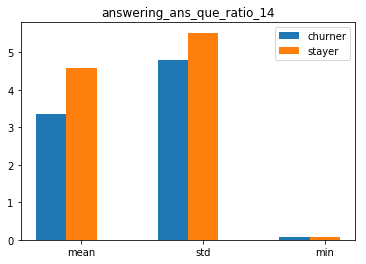

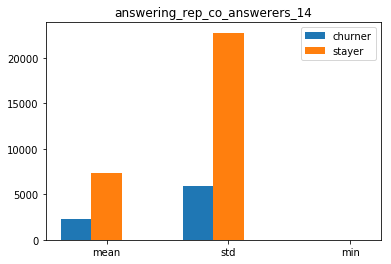

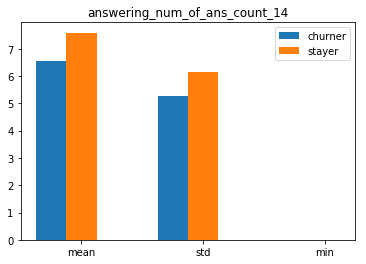

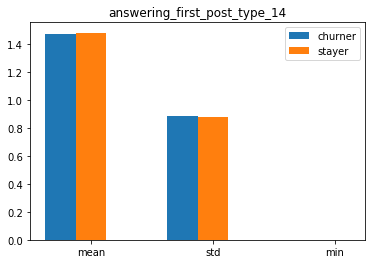

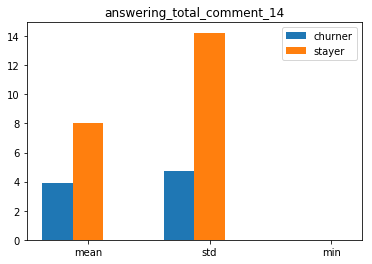


answering, Task 1, K=15
    columns: ['num_answers', 'num_questions', 'ans_que_ratio', 'rep_co_answerers', 'num_of_ans_count', 'first_post_type', 'total_comment']


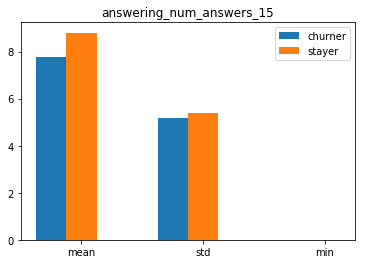

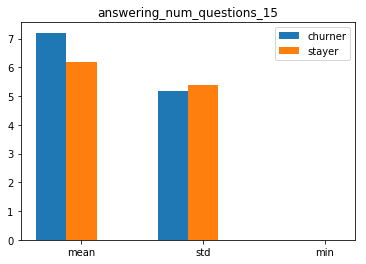

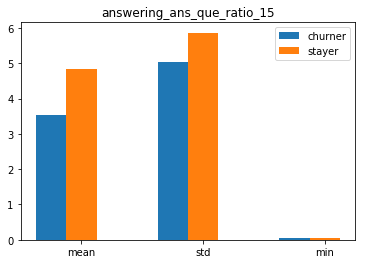

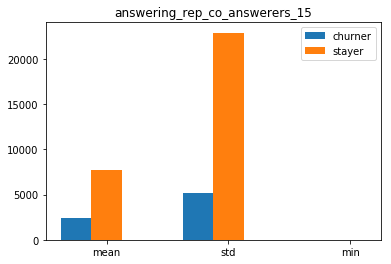

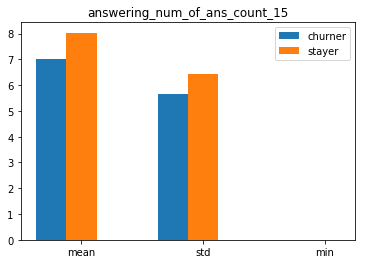

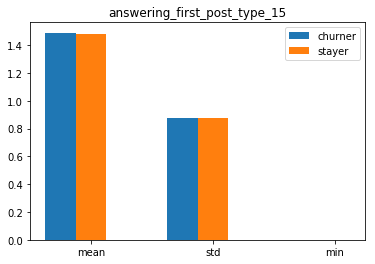

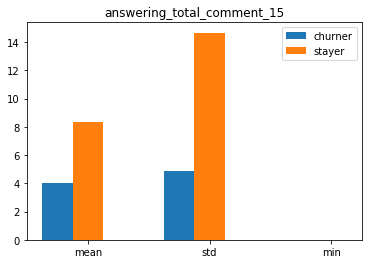


answering, Task 1, K=16
    columns: ['num_answers', 'num_questions', 'ans_que_ratio', 'rep_co_answerers', 'num_of_ans_count', 'first_post_type', 'total_comment']


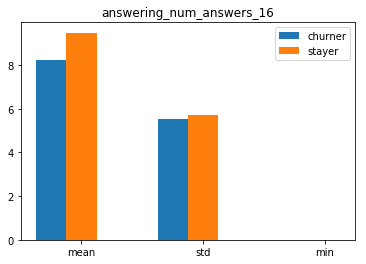

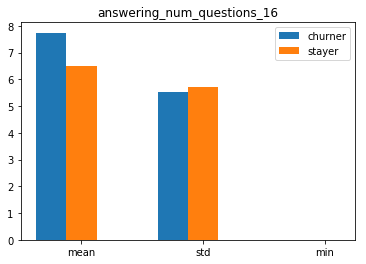

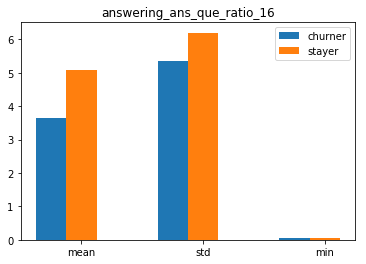

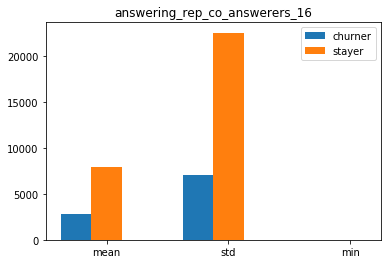

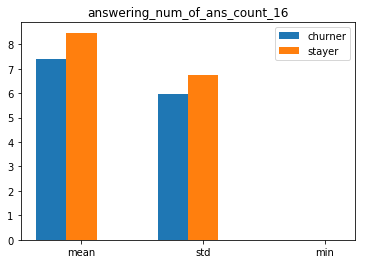

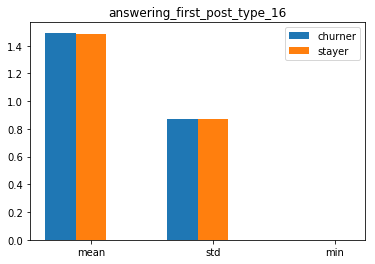

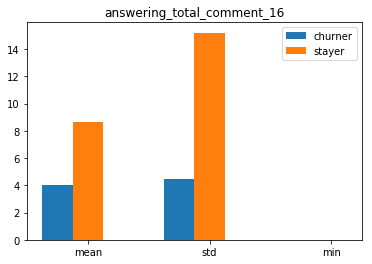


answering, Task 1, K=17
    columns: ['num_answers', 'num_questions', 'ans_que_ratio', 'rep_co_answerers', 'num_of_ans_count', 'first_post_type', 'total_comment']


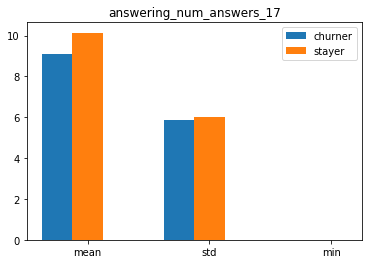

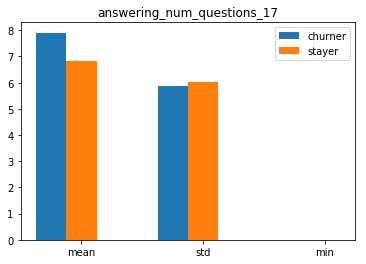

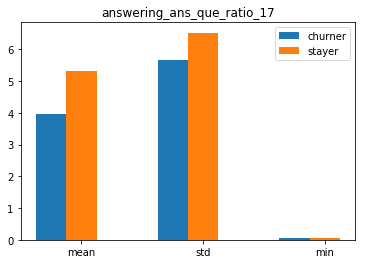

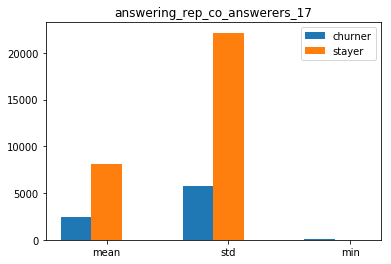

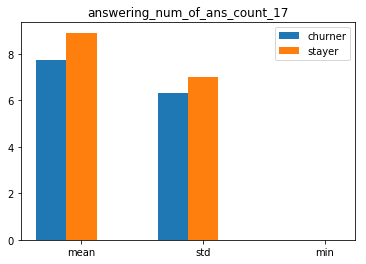

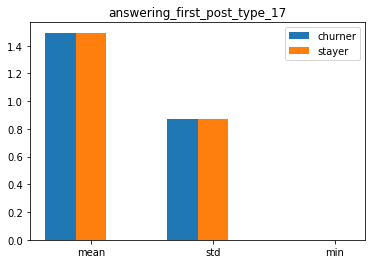

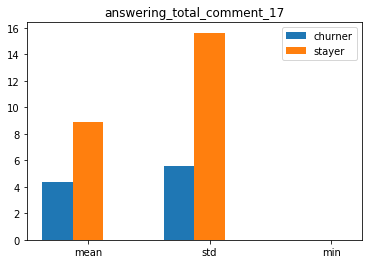


answering, Task 1, K=18
    columns: ['num_answers', 'num_questions', 'ans_que_ratio', 'rep_co_answerers', 'num_of_ans_count', 'first_post_type', 'total_comment']


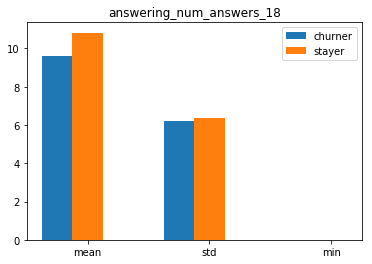

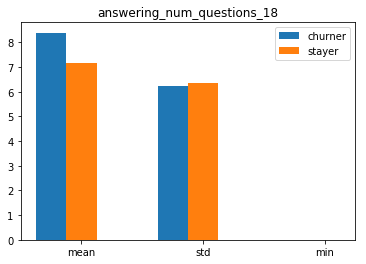

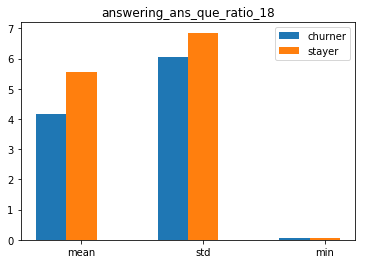

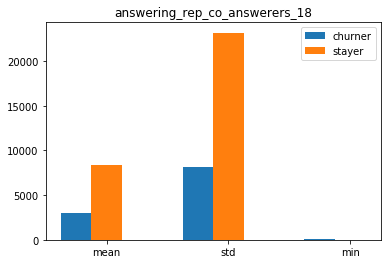

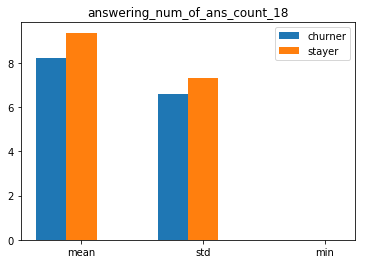

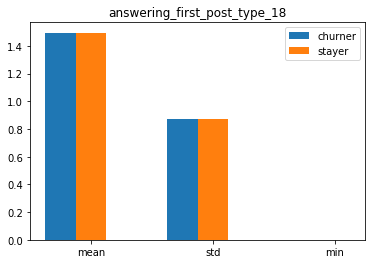

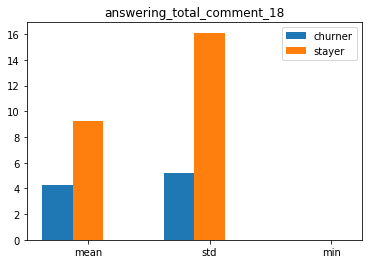


answering, Task 1, K=19
    columns: ['num_answers', 'num_questions', 'ans_que_ratio', 'rep_co_answerers', 'num_of_ans_count', 'first_post_type', 'total_comment']


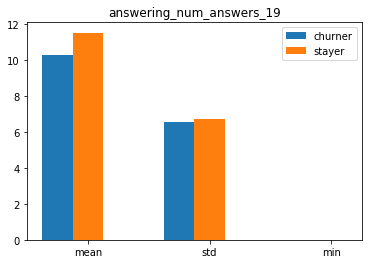

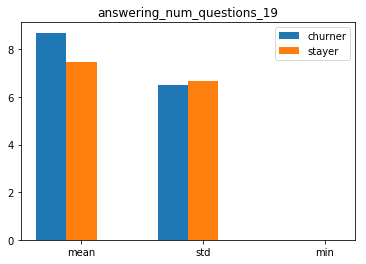

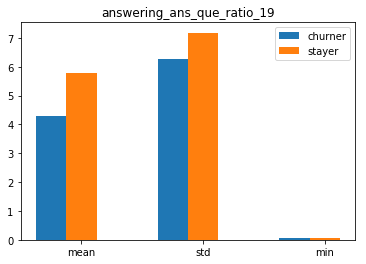

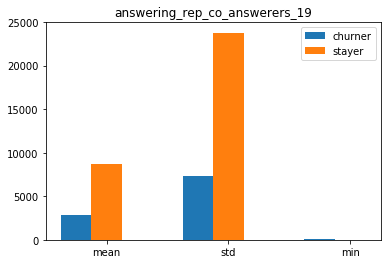

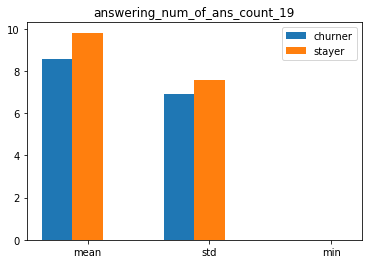

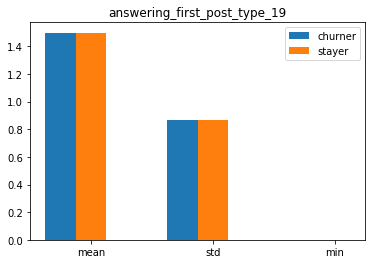

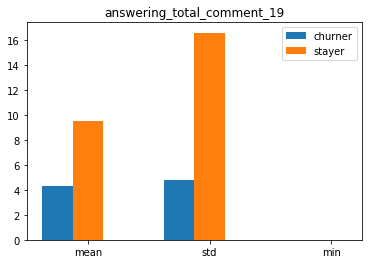


answering, Task 1, K=20
    columns: ['num_answers', 'num_questions', 'ans_que_ratio', 'rep_co_answerers', 'num_of_ans_count', 'first_post_type', 'total_comment']


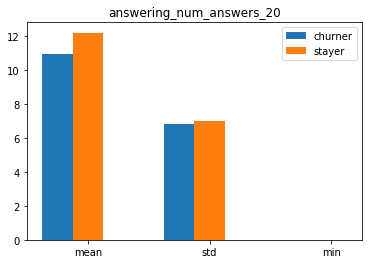

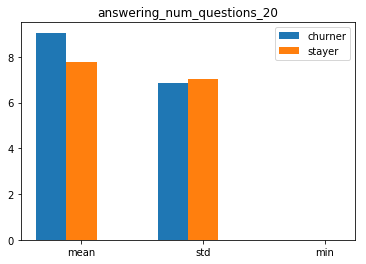

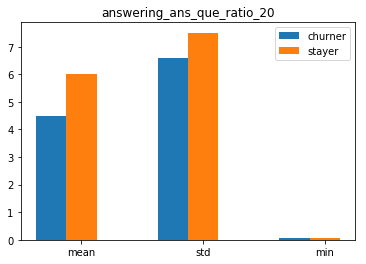

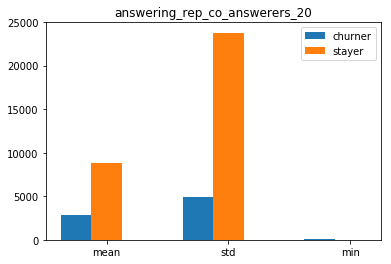

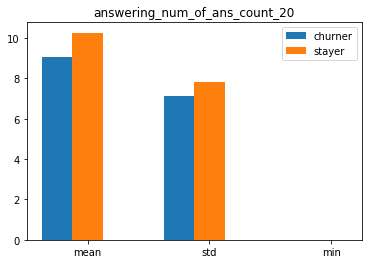

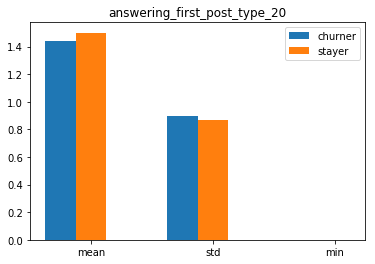

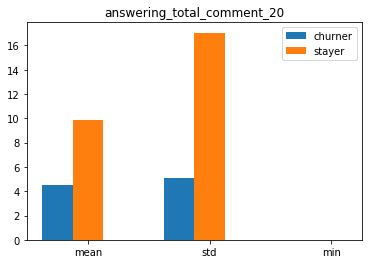

In [71]:
task1_chuner_and_stayer = {}
for name, feature_list in analysis_feature_names.items():
    if name != 'answering':
        continue
        
    for K in list_of_K:
        if name == 'temoral':
            feature_list = ['gap{}'.format(j) for j in range(1, K+1)]
        elif name == 'frequency':
            feature_list = [feat for feat in feature_list if feat != 'num_posts']
        train_features = [feat for feat in feature_list if feat in features_of_task1[K].columns]
        if len(train_features) == 0:
            continue
        print('\n{}, Task 1, K={}'.format(name, K))
        print('    columns: {}'.format(train_features))
        
        subgroup = features_of_task1[K][train_features + ['is_churn']]
        if 'accepted_answerer_rep' in train_features:
            print(subgroup['accepted_answerer_rep'])
#             subgroup = subgroup.fillna({'accepted_answerer_rep':1})
        churners = subgroup[subgroup['is_churn'] == 1]
        stayers = subgroup[subgroup['is_churn'] == 0]
        for col in train_features:
            target = ['mean', 'std', 'min']
            barWidth = 0.25
            n_groups = len(target)
        #     index = np.arange(n_groups)

            r1 = np.arange(n_groups)
            r2 = [x + barWidth for x in r1]


            plt.bar(r1, churners[col].describe()[target], tick_label=target, width=barWidth, align='center', label='churner')
            plt.bar(r2, stayers[col].describe()[target], tick_label=target, width=barWidth, align='center', label='stayer')

            plt.title(name + '_' + col + '_' +str(K))
#             plt.xlim(-1, n_groups)
            plt.legend()
#             plt.ylim(0, 100)
            plt.show()
#         list_of_churner_and_stayer.append((churners, stayers))

#     task1_chuner_and_stayer[name] = list_of_churner_and_stayer
    
# # Bar Chart
# for title, churner_and_stayer in task1_chuner_and_stayer.items():
#     if len(churner_and_stayer) == 0:
#         continue
#     n_groups = len(list_of_K)
# #     index = np.arange(n_groups)
    
#     r1 = np.arange(n_groups)
#     r2 = [x + 0.25 for x in r1]


#     plt.bar(r1, churner_and_stayer[0][0], tick_label=list_of_K, align='center')
#     plt.bar(r2, churner_and_stayer[0][1], tick_label=list_of_K, align='center')

#     plt.title(title)
#     plt.xlim(-1, n_groups)
#     plt.ylim(0, 100)
#     plt.show()


answering, Task 2, T=7
    columns: ['num_answers', 'num_questions', 'ans_que_ratio', 'rep_co_answerers', 'num_of_ans_count', 'first_post_type', 'total_comment']


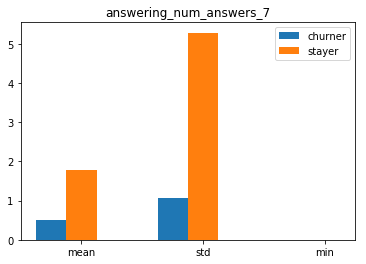

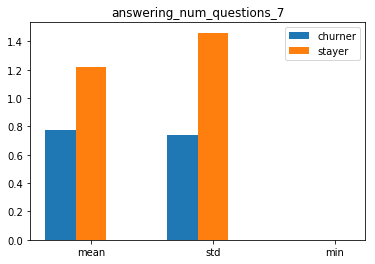

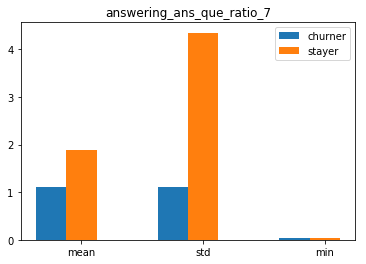

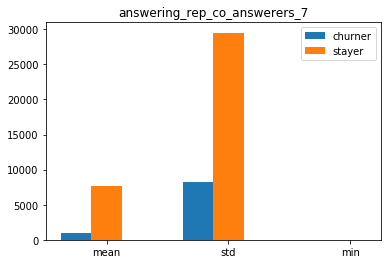

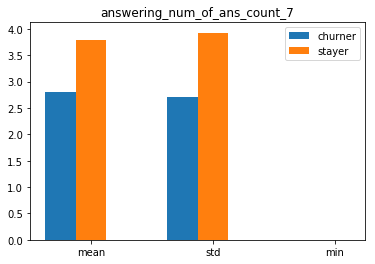

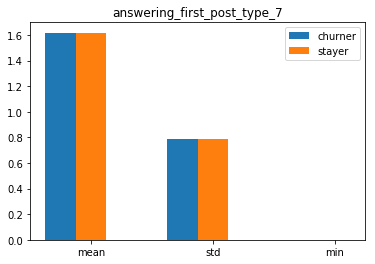

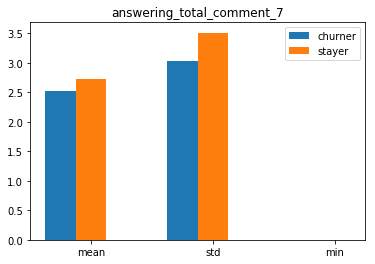


answering, Task 2, T=15
    columns: ['num_answers', 'num_questions', 'ans_que_ratio', 'rep_co_answerers', 'num_of_ans_count', 'first_post_type', 'total_comment']


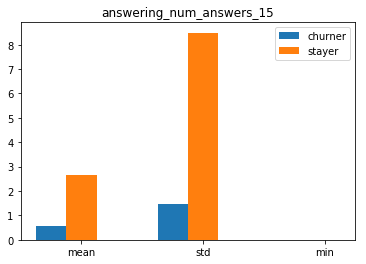

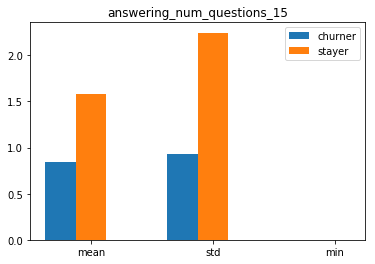

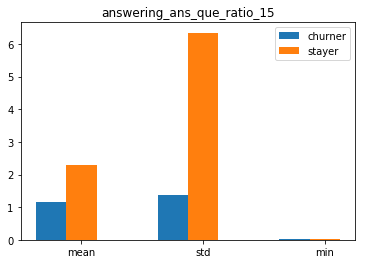

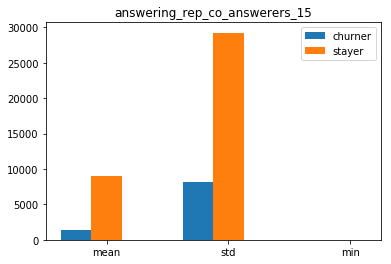

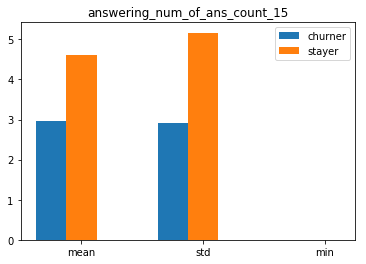

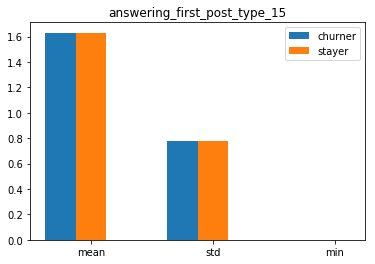

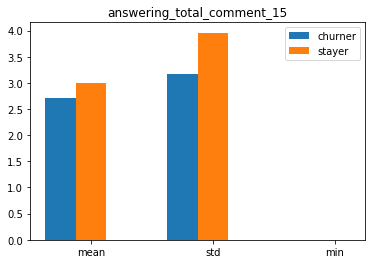


answering, Task 2, T=30
    columns: ['num_answers', 'num_questions', 'ans_que_ratio', 'rep_co_answerers', 'num_of_ans_count', 'first_post_type', 'total_comment']


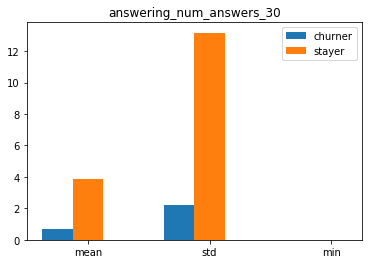

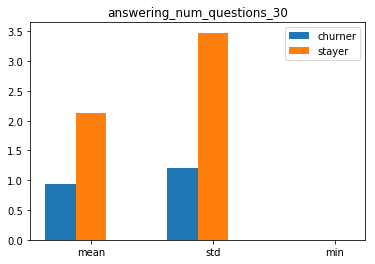

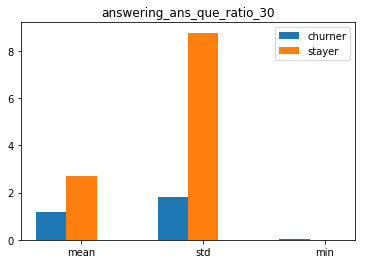

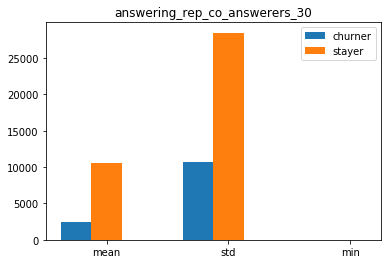

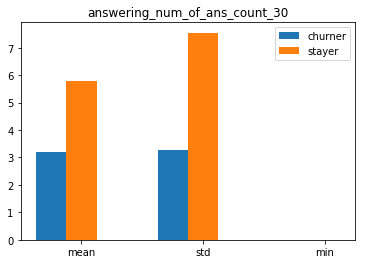

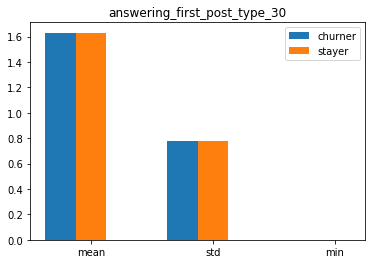

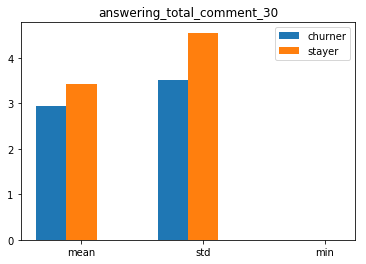

In [72]:
task2_chuner_and_stayer = {}
for name, feature_list in analysis_feature_names.items():
    if name != 'answering':
        continue
        
    for T in list_of_T:
        train_features = [feat for feat in feature_list if feat in features_of_task2[T].columns]
        if len(train_features) == 0:
            continue
        print('\n{}, Task 2, T={}'.format(name, T))
        print('    columns: {}'.format(train_features))

        subgroup = features_of_task2[T][train_features + ['is_churn']]
        churners = subgroup[subgroup['is_churn'] == 1]
        stayers = subgroup[subgroup['is_churn'] == 0]
        for col in train_features:
            target = ['mean', 'std', 'min']
            barWidth = 0.25
            n_groups = len(target)
        #     index = np.arange(n_groups)

            r1 = np.arange(n_groups)
            r2 = [x + barWidth for x in r1]


            plt.bar(r1, churners[col].describe()[target], tick_label=target, width=barWidth, align='center', label='churner')
            plt.bar(r2, stayers[col].describe()[target], tick_label=target, width=barWidth, align='center', label='stayer')

            plt.title(name + '_' + col + '_' +str(T))
#             plt.xlim(-1, n_groups)
            plt.legend()
#             plt.ylim(0, 100)
            plt.show()
#         list_of_churner_and_stayer.append((churners, stayers))

#     task1_chuner_and_stayer[name] = list_of_churner_and_stayer
    
# # Bar Chart
# for title, churner_and_stayer in task1_chuner_and_stayer.items():
#     if len(churner_and_stayer) == 0:
#         continue
#     n_groups = len(list_of_K)
# #     index = np.arange(n_groups)
    
#     r1 = np.arange(n_groups)
#     r2 = [x + 0.25 for x in r1]


#     plt.bar(r1, churner_and_stayer[0][0], tick_label=list_of_K, align='center')
#     plt.bar(r2, churner_and_stayer[0][1], tick_label=list_of_K, align='center')

#     plt.title(title)
#     plt.xlim(-1, n_groups)
#     plt.ylim(0, 100)
#     plt.show()

3-10. Extract all features for each tasks

In [0]:
!wget https://developer.nvidia.com/compute/cuda/9.0/Prod/local_installers/cuda-repo-ubuntu1604-9-0-local_9.0.176-1_amd64-deb
!dpkg -i cuda-repo-ubuntu1604-9-0-local_9.0.176-1_amd64-deb
!apt-key add /var/cuda-repo-9-0-local/7fa2af80.pub
!apt-get update
!apt-get install cuda=9.0.176-1

In [0]:
!nvcc --version

In [0]:
!pip3 install thundersvm

In [0]:
!pip3 install numpy matplotlib scikit-learn

4. Analyze features


5. Train models for each tasks with the features

    1. Decision Tree
    2. SVM (Linear)
    3. SVM (RBF)
    4. Logistic Regression
    

In [0]:
def fill_nan(features):
    if 'time_for_first_ans' in features.columns and np.isnan(features['time_for_first_ans']).sum(0):
        features['time_for_first_ans'] = 1 / features['time_for_first_ans']
        features['time_for_first_ans'] = features['time_for_first_ans'].replace([np.nan], 0)
    fill_constants = {
        'accepted_answerer_rep': 0,
        'max_rep_answerer': 0,
        'num_que_answered': 0, 
        'rep_questioner': 0,
        'rep_answerers': 0,
        'rep_co_answerers': 0,
        'num_answers_recvd': 0,
        'ans_length': 0,
        'que_length': 0,
        'answering_speed': 0,
        'ans_score': 0,
        'que_score': 0,
        'ans_stddev': 0,
        'que_stddev': 0,
        'ans_comments': 0,
        'que_comments': 0,
        'relative_rank_pos': 0,
        'num_of_ans_count': 0, 
        'first_post_type': 0,
        'total_comment': 0
    }
    return features.fillna(fill_constants)
                                                                         

In [74]:
for K in list_of_K:
    print("Fill NaN of task1(K=",K,")")
    features_of_task1[K] = fill_nan(features_of_task1[K])


Fill NaN of task1(K= 1 )
Fill NaN of task1(K= 2 )
Fill NaN of task1(K= 3 )
Fill NaN of task1(K= 4 )
Fill NaN of task1(K= 5 )
Fill NaN of task1(K= 6 )
Fill NaN of task1(K= 7 )
Fill NaN of task1(K= 8 )
Fill NaN of task1(K= 9 )
Fill NaN of task1(K= 10 )
Fill NaN of task1(K= 11 )
Fill NaN of task1(K= 12 )
Fill NaN of task1(K= 13 )
Fill NaN of task1(K= 14 )
Fill NaN of task1(K= 15 )
Fill NaN of task1(K= 16 )
Fill NaN of task1(K= 17 )
Fill NaN of task1(K= 18 )
Fill NaN of task1(K= 19 )
Fill NaN of task1(K= 20 )


In [75]:
for T in list_of_T:
    print("Fill NaN of task2(T=)",T,")")
    features_of_task2[T] = fill_nan(features_of_task2[T])


Fill NaN of task2(T=) 7 )
Fill NaN of task2(T=) 15 )
Fill NaN of task2(T=) 30 )


In [0]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.utils import resample
# from thundersvm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, GridSearchCV

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

seed = 1234
np.random.seed(seed)

def LogisticRegression_(*arg, **kwarg):
    kwarg['max_iter'] = 1e4
    kwarg['solver'] = 'saga'
    kwarg['n_jobs'] = 8
    return LogisticRegression(*arg, **kwarg)

# def LinearSVC_(*arg, **kwarg):
    
#     return SVC(*arg, **kwarg)

def SVC_(*arg, **kwarg):
    kwarg['max_iter'] = 1e4
    kwarg['gamma'] = 'scale'
    
    return SVC(*arg, **kwarg)

  

In [0]:
def learn_model(data, train_features, target='is_churn', model=DecisionTreeClassifier, seed=seed):
    X = data[train_features]
    y = data[target]
    print(model.__name__)
  
    ### 10-fold cross validation ###
    acc_list = []
    kf = KFold(n_splits=10, shuffle=True, random_state=seed)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        ### Under-sampling ###
        churners = y_train[y_train == 1].index
        stayers = y_train[y_train == 0].index
        n_churn = len(churners)
        n_stay = len(stayers)
#         X_t, y_t = resample(X_train, y_train, n_samples=len(y_train)/4, replace=False, stratify=y, random_state=seed)
#         print(X_train)
        if n_churn > n_stay:
            churners = np.random.choice(churners, n_stay, replace=False)
        else:
            stayers = np.random.choice(stayers, n_churn, replace=False)
        train_index = np.array(list(churners) + list(stayers))
        X_train, y_train = X.reindex(train_index), y.reindex(train_index)
        
        ### Learn Model ###
        mdl = model().fit(X_train, y_train)
        pred = mdl.predict(X_test)  
        acc = (pred == y_test)
        acc_list.append(sum(acc)*100/len(acc))
    return acc_list

In [0]:
import tensorflow as tf
tf.test.gpu_device_name()
# !nvidia-smi

In [78]:
# Table 2: Performance on Task 1

drop_user_columns = ['Reputation', 'CreationDate', 'LastAccessDate', 'num_posts']

# model = LogisticRegression_
model = DecisionTreeClassifier
# model = LinearSVC
# model = SVC_

for K in list_of_K:
    print('Task 1, K={}'.format(K))
    train_features = [col for col in features_of_task1[K].columns 
                      if col not in drop_user_columns + ['is_churn']]

    acc_list = learn_model(features_of_task1[K], train_features, model=model)
    print('Accuracy: {}'.format(np.mean(acc_list)))
    print('    for each folds: {}'.format(acc_list))


Task 1, K=1
DecisionTreeClassifier
Accuracy: 57.759135579376405
    for each folds: [57.87613392997057, 57.77514669266798, 57.602771925548026, 58.26194456052375, 57.7970469424711, 57.694316757208526, 57.70302270511213, 57.48885638668338, 57.60899846775317, 57.783117425825324]
Task 1, K=2
DecisionTreeClassifier
Accuracy: 55.57957921171103
    for each folds: [55.544666646249965, 55.92747986402475, 56.05610510519707, 55.67329188742229, 55.746792025235045, 55.04854071601384, 55.2966036811319, 55.60591676109393, 55.26597862370992, 55.630416807031516]
Task 1, K=3
DecisionTreeClassifier
Accuracy: 57.003921366856936
    for each folds: [56.91384348100766, 57.02665350444225, 56.983218163869694, 57.409674234945705, 56.612043435340574, 56.454096742349456, 56.95162882527147, 57.20829220138204, 56.99111549851925, 57.48864758144126]
Task 1, K=4
DecisionTreeClassifier
Accuracy: 58.58026703208352
    for each folds: [59.071395240317315, 58.22211852543164, 58.79141390573962, 58.49276714885674, 58.2061

In [79]:
# Table 3: Performance on Task 2

drop_user_columns = ['Reputation', 'CreationDate', 'LastAccessDate']

# model = LogisticRegression_
model = DecisionTreeClassifier
# model = LinearSVC
# model = SVC_

for T in list_of_T:
    print('Task 2, T={}'.format(T))
    train_features = [col for col in features_of_task2[T].columns 
                      if col not in drop_user_columns + ['is_churn']]

    acc_list = learn_model(features_of_task2[T], train_features, model=model)
    print('Accuracy: {}'.format(np.mean(acc_list)))
    print('    for each folds: {}'.format(acc_list))


Task 2, T=7
DecisionTreeClassifier
Accuracy: 64.98910844441721
    for each folds: [65.40847511745655, 65.40847511745655, 65.01391232951694, 64.87478903434749, 64.69689367331114, 64.76679210856426, 65.18417151328543, 64.88083019728589, 64.69152697000798, 64.9652183829399]
Task 2, T=15
DecisionTreeClassifier
Accuracy: 66.25504365671792
    for each folds: [66.41733582664173, 66.03893961060389, 66.53539842478109, 66.19879438553262, 65.88419061028732, 66.104193250319, 66.52879834558014, 65.95679148149777, 66.44079728956747, 66.4451973423681]
Task 2, T=30
DecisionTreeClassifier
Accuracy: 67.31823919321087
    for each folds: [67.18862567275501, 67.05937195406196, 67.49374920540747, 67.2945713438149, 66.96613976352926, 67.3750900538204, 67.24726124637128, 67.56934291102495, 67.65410124382853, 67.33413853749497]


In [0]:
# Figure 5: Churn prediction accuracy when features from each category are used in isolation

temporal_features = ['gap1', 'last_gap', 'time_since_last_post', 'mean_gap']
frequency_features = ['num_answers', 'num_questions',
                      'ans_que_ratio', 'num_posts']
speed_features = ['answering_speed']
quality_features = ['ans_score', 'que_score']
consistency_features = ['ans_stddev', 'que_stddev']
gratitude_features = ['ans_comments', 'que_comments']
competitiveness_features = ['relative_rank_pos']
content_features = ['ans_length', 'que_length']
knowledge_features = ['accepted_answerer_rep', 'max_rep_answerer',
                      'num_que_answered', 'time_for_first_ans',
                      'rep_questioner', 'rep_answerers',
                      'rep_co_answerers', 'num_answers_recvd']
answering_features = ['num_answers', 'num_questions', 'ans_que_ratio', 'rep_co_answerers',
                      'num_of_ans_count', 'first_post_type', 'total_comment']
answering_old_features = ['num_answers', 'num_questions', 'ans_que_ratio', 'rep_co_answerers']
answering_new_features = ['num_of_ans_count', 'first_post_type', 'total_comment']

analysis_feature_names = {
    'temporal': temporal_features,
    'frequency': frequency_features,
    'speed': speed_features,
    'quality': quality_features,
    'consistency': consistency_features,
    'gratitude': gratitude_features,
    'competitiveness': competitiveness_features,
    'content': content_features,
    'knowledge': knowledge_features,
    'answering': answering_features,
    'answering_old' : answering_old_features,
    'answering_new' : answering_new_features
}

In [81]:
task1_accuracy_of_category = {}
for name, feature_list in analysis_feature_names.items():
    accuracy_of_category = []
    for K in list_of_K:
        if name == 'temoral':
            feature_list = ['gap{}'.format(j) for j in range(1, K+1)]
        elif name == 'frequency':
            feature_list = [feat for feat in feature_list if feat != 'num_posts']
        train_features = [feat for feat in feature_list if feat in features_of_task1[K].columns]
        if len(train_features) == 0:
            continue
        print('\n{}, Task 1, K={}'.format(name, K))
        print('    columns: {}'.format(train_features))

        acc_list = learn_model(features_of_task1[K], train_features)
        mean_acc = np.mean(acc_list)
        accuracy_of_category.append(mean_acc)
        print('Accuracy: {}'.format(mean_acc))
        print('    for each folds: {}'.format(acc_list))

    task1_accuracy_of_category[name] = accuracy_of_category


temporal, Task 1, K=1
    columns: ['gap1']
DecisionTreeClassifier
Accuracy: 58.77563696942855
    for each folds: [59.00266397367367, 58.682290669127504, 58.49076315010534, 58.73380693689929, 58.810419278451036, 58.70072433486558, 59.04547987184845, 58.46218136230673, 59.13776291962669, 58.69027719738125]

temporal, Task 1, K=2
    columns: ['gap1']
DecisionTreeClassifier
Accuracy: 49.932624873671635
    for each folds: [49.65853060974489, 49.89434355189416, 49.98621872416011, 50.23734419502036, 50.10259394236364, 50.0107187700977, 49.77796833369062, 49.796343368143816, 50.01990628732429, 49.84228095427679]

temporal, Task 1, K=3
    columns: ['gap1']
DecisionTreeClassifier
Accuracy: 49.150054035748965
    for each folds: [48.8154465766406, 49.17670286278381, 49.30700888450148, 48.50148075024679, 48.89634748272458, 49.55577492596249, 49.55577492596249, 49.45705824284304, 48.87265547877591, 49.36229022704837]

temporal, Task 1, K=4
    columns: ['gap1']
DecisionTreeClassifier
Accuracy

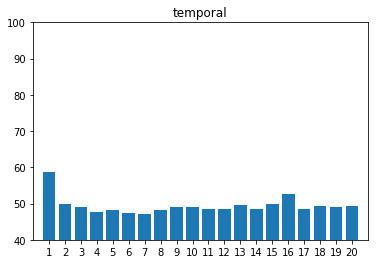

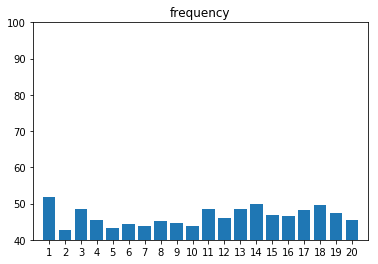

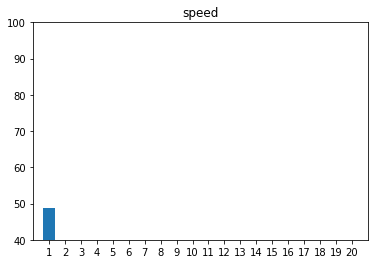

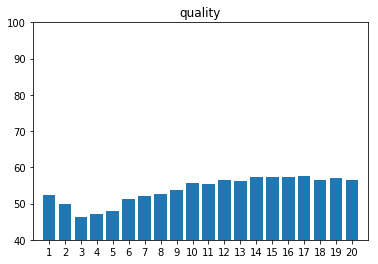

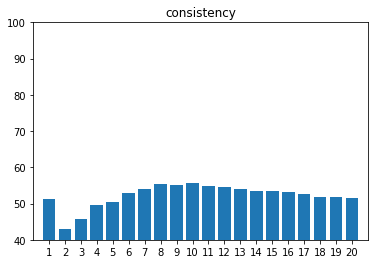

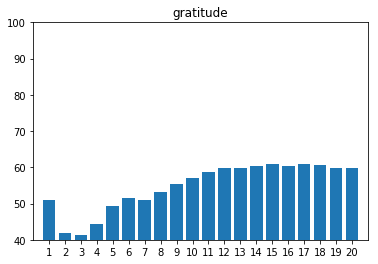

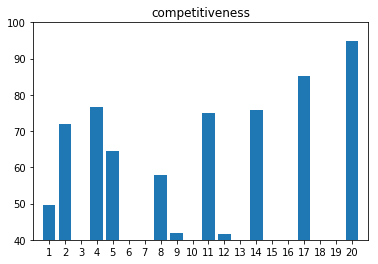

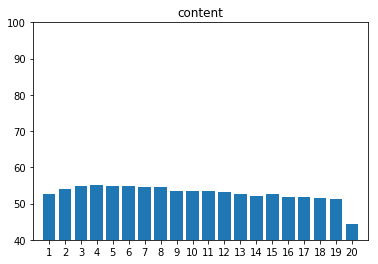

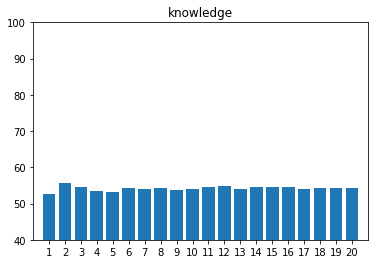

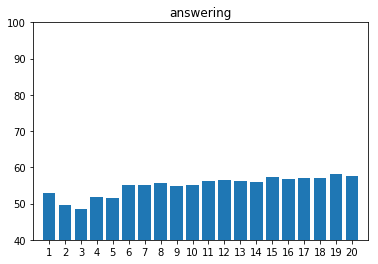

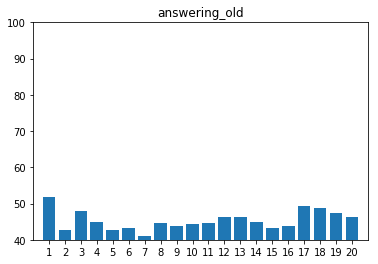

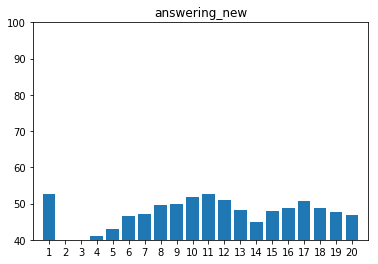

In [82]:
# Bar Chart
for title, predictions in task1_accuracy_of_category.items():
    if len(predictions) == 0:
        continue
    n_groups = len(list_of_K)
    index = np.arange(n_groups)

    plt.bar(index, predictions, tick_label=list_of_K, align='center')

    plt.title(title)
    plt.xlim(-1, n_groups)
    plt.ylim(40, 100)
    plt.show()


In [83]:
### Category Analysis - Task 2 ###
task2_accuracy_of_category = {}
for name, feature_list in analysis_feature_names.items():
    accuracy_of_category = []
    for T in list_of_T:
        train_features = [feat for feat in feature_list if feat in features_of_task2[T].columns]
        if len(train_features) == 0:
            continue
        print('\n{}, Task 2, T={}'.format(name, T))
        print('    columns: {}'.format(train_features))

        acc_list = learn_model(features_of_task2[T], train_features)
        mean_acc = np.mean(acc_list)
        accuracy_of_category.append(mean_acc)
        print('Accuracy: {}'.format(mean_acc))
        print('    for each folds: {}'.format(acc_list))

    task2_accuracy_of_category[name] = accuracy_of_category


temporal, Task 2, T=7
    columns: ['gap1', 'last_gap', 'time_since_last_post', 'mean_gap']
DecisionTreeClassifier
Accuracy: 66.19767122394039
    for each folds: [66.27286411531269, 66.13830223965698, 66.24093417871642, 66.3686539251015, 66.0311088810838, 65.95278823126924, 66.50245181890752, 66.16717983806592, 66.06682631999088, 66.2356026912989]

temporal, Task 2, T=15
    columns: ['gap1', 'last_gap', 'time_since_last_post', 'mean_gap']
DecisionTreeClassifier
Accuracy: 67.44437264343861
    for each folds: [67.45132548674513, 67.40732592674074, 67.44840938091257, 67.23940687288247, 67.59801117613411, 67.28780745368944, 67.5056100673208, 67.12940555286663, 67.71241254895058, 67.66401196814361]

temporal, Task 2, T=30
    columns: ['gap1', 'last_gap', 'time_since_last_post', 'mean_gap']
DecisionTreeClassifier
Accuracy: 68.33151051463673
    for each folds: [68.30953087256854, 68.41335763020723, 68.28622282493538, 68.27986608467178, 68.49599525363394, 68.45785481205237, 68.4953276969

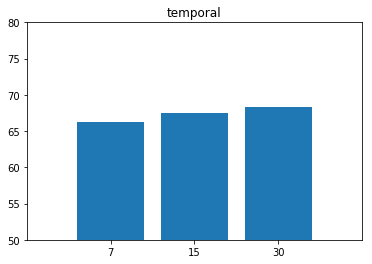

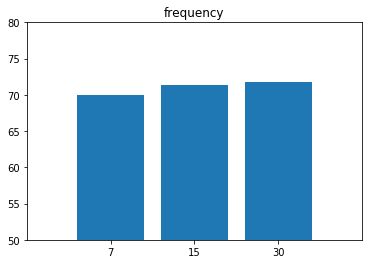

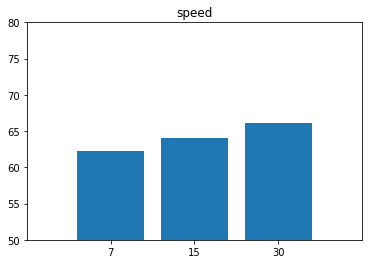

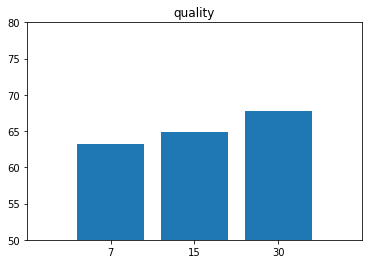

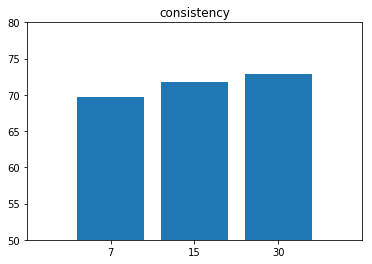

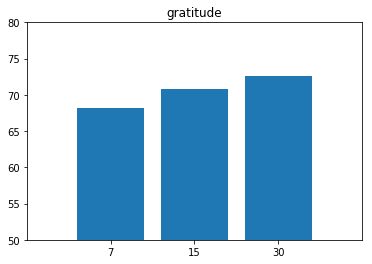

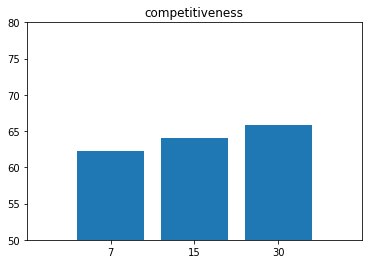

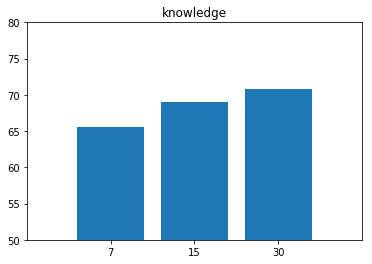

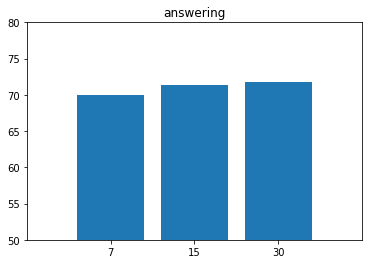

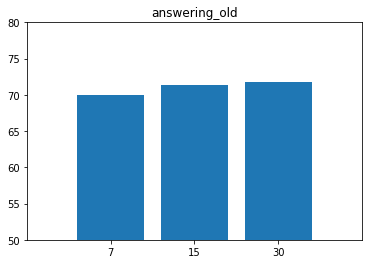

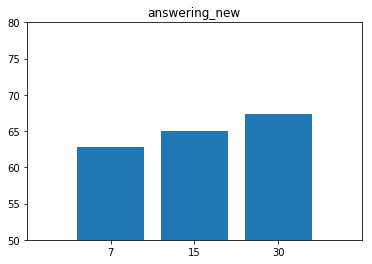

In [84]:
# Bar Chart
for title, predictions in task2_accuracy_of_category.items():
    if len(predictions) == 0:
        continue
    n_groups = len(list_of_T)
    index = np.arange(n_groups)

    plt.bar(index, predictions, tick_label=list_of_T, align='center')

    plt.title(title)
    plt.xlim(-1, n_groups)
    plt.ylim(50, 80)
    plt.show()


In [0]:
### Temporal Feature Analysis - Task 1 ###
temporal_analysis_feature_func = {
    'gapK': lambda K: ['gap{}'.format(j) for j in range(1, K+1)],
    'last_gap': lambda K: ['gap{}'.format(K)]
}


task1_accuracy_with_time_gap = {}
for K in list_of_K:
    accuracy_with_time_gap = []
    for name, feature_func in temporal_analysis_feature_func.items():
        train_features = [feat for feat in feature_list if feat in features_of_task1[K].columns]
        if len(train_features) == 0:
            continue
        print('\n{}, Task 1, K={}'.format(name, K))
        print('    columns: {}'.format(train_features))

        acc_list = learn_model(features_of_task1[K], train_features)
        mean_acc = np.mean(acc_list)
        accuracy_with_time_gap.append(mean_acc)
        print('Accuracy: {}'.format(mean_acc))
        print('    for each folds: {}'.format(acc_list))

    task1_accuracy_with_time_gap[K] = accuracy_with_time_gap

In [0]:
# Table 4: Temporal gap features analysis

for K, acc in task1_accuracy_with_time_gap.items():
    print(K, acc)

In [0]:
### Answering Feature Analysis - Task 1 ###
answering_analysis_feature_func = {
    'answering': answering_features,
    'answering_old' : answering_old_features,
    'answering_new' : answering_new_features
}


task1_accuracy_with_answering = {}
for K in list_of_K:
    accuracy_with_answering = []
    for name, feature_func in answering_analysis_feature_func.items():
        train_features = [feat for feat in feature_list if feat in features_of_task1[K].columns]
        if len(train_features) == 0:
            continue
        print('\n{}, Task 1, K={}'.format(name, K))
        print('    columns: {}'.format(train_features))

        acc_list = learn_model(features_of_task1[K], train_features)
        mean_acc = np.mean(acc_list)
        accuracy_with_answering.append(mean_acc)
        print('Accuracy: {}'.format(mean_acc))
        print('    for each folds: {}'.format(acc_list))

    task1_accuracy_with_answering[K] = accuracy_with_answering

In [0]:
for K, acc in task1_accuracy_with_answering.items():
    print(K, acc)